# Analisi dati di allenamento Garmin

Disponendo di un ampio dataset con oltre 75.000 registrazioni provenienti da un dispositivo Garmin (Edge 820), relative ad allenamenti in bicicletta, l'obiettivo è sviluppare modelli predittivi basati su alcuni parametri (come la velocità, la pendenza, ecc.) per prevedere alcuni parametri di interesse.
- *Regressione*:
    - predire il battito cardiaco istantaneo (bpm)
    - predire la potenza istantanea (W)
- *Classificazione*:
    - classificare la zona di frequenza cardiaca
    - classificare la zona di potenza

## Raccolta dei dati
Poiché i dati non sono stati raccolti da siti noti come [UCI](https://archive.ics.uci.edu/), [Kaggle](https://www.kaggle.com/), ecc. bensì da allenamenti svolti personalmente da Riccardo Fiorani, è stato necessario estrarre i dati dai file *.fit* e *.tcx* messi a disposizione da Garmin e convertirli in *.csv* in modo da poterli analizzare con Python.
Per fare questo si è utilizzato il tool [Fit File Repair Tool](https://www.fitfilerepairtool.info/), che permette di convertire i file *.fit* in *.csv*.
Aggiungi ulteriore descrizione....

## Descrizione dei dati
Non essendo i dati provenienti da un dataset noto, è necessario descriverli in modo da poterli analizzare e comprendere meglio.
I *CSV* e i formati originali sono visionabili nella cartella del progetto `garmin_edge_820/`.
In particolare il dataset utilizzato è dato dall'unione di 4 allenamenti, ciascuno relativo a un allenamento.
Ogni record rappresenta un istante di un dato allenamento, raccolto con cadenza di un secondo, e contiene le seguenti informazioni:
- `timestamp`: data e ora dell'istante
- `distance`: distanza percorsa dall'inizio dell'allenamento (m)
- `accumulated_power`: potenza accumulata da inizio allenamento (W)
- `altitude`: altitudine (m)
- `speed`: velocità istantanea (m/s)
- `power`: potenza istantanea (W)
- `heart_rate`: frequenza cardiaca (bpm)
- `cadence`: cadenza di pedalata (rpm)
- `temperature`: temperatura (°C)
- `left_right_balance`: bilanciamento destro/sinistro, corrisponde alla percentuale di potenza applicata dal piede destro in rapporto a quella applicata dal piede sinistro. 
- `left_pco`: parametro Garmin che indica la distribuzione della forza lungo la battuta del pedale durante la pedalata. In questo caso relativo al piede sinistro. Il PCO si misura in millimetri. Valori positivi (ad es. +6 mm) indicano una forza maggiore verso l'esterno del pedale, mentre valori negativi (ad es. -4 mm) indicano una maggiore forza verso l'interno del pedale. Si veda la seguente immagine per ulteriori informazioni
<div align="center"><img src="imgs/pco.png" width="200"></div>

- `right_pco`: come sopra ma relativo al piede destro.
- `left_power_phase`: I sensori di potenza Garmin rilevano il punto in cui la gamba genera una coppia positiva in una pedalata e dove si verifica la maggiore concentrazione di coppia positiva. Inoltre, rilevano l'angolo a cui queste forze iniziano e terminano e il punto in cui si produce la concentrazione di potenza.
<div align="center"><img src="imgs/pwrphase.png" width="200"></div>

- `left_power_phase_peak`: picco massimo di power phase sinistra.
- `right_power_phase`: power phase destro.
- `right_power_phase_peak`: picco massimo di power phase destra.

A questi parametri sono stati aggiunti altri parametri derivati, come:
- `time_since_start`: tempo trascorso dall'inizio dell'allenamento (s). Volevamo verificare se vi è una correlazione fra tempo trascorso e frequenza cardiaca, potenza, ecc.
- `hr_zone`: zona di frequenza cardiaca. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 128)
    - Zona 2: (129, 146)
    - Zona 3: (147, 156)
    - Zona 4: (157, 165)
    - Zona 5: (166, 174)
    - Zona 6: (175, 179)
    - Zona 7: $\geq$ 180
- `pwr_zone`: zona di potenza. Per calcolarla abbiamo usato i seguenti intervalli suggeriti da Garmin 
    - Zona 1: (0, 157)
    - Zona 2: (158, 186)
    - Zona 3: (187, 200)
    - Zona 4: (201, 218)
    - Zona 5: (219, 247)
    - Zona 6: (248, 287)
    - Zona 7: $\geq$ 288
- `altitude_diff`: differenza di altitudine rispetto al secondo precedente (m)
- `distance_diff`: differenza di distanza rispetto al secondo precedente (m)
- `slope_percent`: pendenza istantanea (%), calcolata come 
$$
\frac{\text{\texttt{altitude\_diff}}}{\text{\texttt{distance\_diff}}}
$$

In totale il dataset è composto da 77.620 record.

## Preparazione dei dati

Di seguito sono riportate le operazioni di preparazione dei dati effettuate prima di procedere con l'analisi vera e propria.

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install lightgbm
%pip install xgboost
%pip install flask
%pip install keras-tuner
%pip install tensorflow

In [1]:
import numpy as np
import pandas as pd

In [2]:
file_list = ["garmin_edge_820/3993730634_ACTIVITY_data.csv",
             "garmin_edge_820/4557226804_ACTIVITY_data.csv",
             "garmin_edge_820/4593452980_ACTIVITY_data.csv",
             "garmin_edge_820/5191513011_ACTIVITY_data.csv",
]
combined_df = pd.concat([pd.read_csv(file, sep=";") for file in file_list], ignore_index=True)

In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65344 entries, 0 to 65343
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp[s]                     65344 non-null  int64  
 1   distance[m]                      65344 non-null  float64
 2   altitude[m]                      65344 non-null  float64
 3   speed[m/s]                       65332 non-null  float64
 4   power[watts]                     65344 non-null  int64  
 5   heart_rate[bpm]                  65344 non-null  int64  
 6   temperature[C]                   65344 non-null  int64  
 7   cadence[rpm]                     65344 non-null  int64  
 8   accumulated_power[watts]         65344 non-null  int64  
 9   left_pco[mm]                     65344 non-null  int64  
 10  right_pco[mm]                    65344 non-null  int64  
 11  right_power_phase[degrees]       65344 non-null  object 
 12  right_power_phase_

Poiché alcuni modelli (LGBM Regressor) non supportano features aventi caratteri non unicode, abbiamo sostituito le parentesi quadre con delle tonde usando il metodo `convert_brackets`

In [4]:
def convert_brackets(string):
    return string.replace('[', '(').replace(']', ')')

combined_df.columns = [convert_brackets(col) for col in combined_df.columns]

Per questioni di errore di misurazione, abbiamo visto che alcuni record presentano valori di `speed(m/s)`, `power(watts)`, e di `cadence(rpm)` uguali a 0. Non essendo quei record rilevanti per l'analisi, abbiamo deciso di eliminarli. Inoltre, come mostrato nel `combined_df.info()` superiore, esistono molti valori di `speed(m/s)` posti a `NaN`. Abbiamo deciso di eliminare anche questi record.

Come mostra il grafico precedente il battito cardiaco è molto impreciso su valori bassi. Poiché è altamente iprobabile aver raggiunto 30 bpm durante un allenamento, abbiamo deciso di eliminare i record con frequenza cardiaca inferiore ad una soglia che, visionando il grafico, abbiamo deciso di porre a 80bpm.
Infatti si può notare che nel secondo e terzo allenamento le frequenze vanno anche sotto gli 80bpm ma assumendo valori troppo bassi o non attendibili (linea piatta).

In [5]:
combined_df = combined_df[combined_df['speed(m/s)'] > 0]
combined_df = combined_df[combined_df['power(watts)'] > 0]
combined_df = combined_df[combined_df['cadence(rpm)'] > 0]
combined_df = combined_df[combined_df['heart_rate(bpm)'] > 80]
combined_df = combined_df.dropna(subset=['speed(m/s)'])

Di seguito è invece implementata una funzione che genera le zone di frequenza cardiaca e di potenza.

In [6]:
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165),(166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218),(219, 247), (248, 287), (288, float('inf'))]

def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return zone
        
combined_df['hr_zone'] = combined_df['heart_rate(bpm)'].apply(get_zone, zones=hr_zones)
combined_df['pwr_zone'] = combined_df['power(watts)'].apply(get_zone, zones=power_zones)

A questo punto si calcolano le features relative alla differenza di altitudine e distanza dall'istante successivo. Successivamente vengono utilizzate per calcolare la pendenza istantanea.

In [7]:
combined_df['altitude_diff(m)'] = combined_df['altitude(m)'] - combined_df['altitude(m)'].shift(1)
combined_df['distance_diff(m)'] = combined_df['distance(m)'] - combined_df['distance(m)'].shift(1)
combined_df[['altitude_diff(m)', 'distance_diff(m)']] = combined_df[['altitude_diff(m)', 'distance_diff(m)']].fillna(0)
combined_df['slope_percent'] = np.where(combined_df['distance_diff(m)'] == 0, 0, combined_df['altitude_diff(m)'] / combined_df['distance_diff(m)'] * 100)

Anche la potenza, come mostrato nel grafico precedente, presenta valori molto instabili. In particolare si notano
- molti buchi, cioè linee rette nel grafico, che indicano che il sensore non ha rilevato la potenza
- picchi molto alti susseguiti da picchi molto bassi. Questo è dovuto al fatto che il sensore di potenza è molto sensibile e rileva anche piccole variazioni di potenza.

Per questo motivo abbiamo deciso di calcolare la media mobile con finestra di 3 secondi. Questo ci permette di avere una visione più chiara della potenza durante l'allenamento.

In [8]:
window_size = 6
combined_df['avg_power(watts)'] = combined_df['power(watts)'].rolling(window=int(window_size), center=True).mean()
combined_df = combined_df.dropna(subset=['avg_power(watts)'])
combined_df['avg_power(watts)'] = combined_df['avg_power(watts)'].astype('int64')


Il parametro `left_right_balance` di Garmin va trattato per visualizzare l'effettiva potenza di spinta da gamba sinistra e destra. In particolare Garmin suggerisce di usare la seguente formula
$$
\text{\texttt{left\_power}} = \text{\texttt{left\_right\_balance}} - 128 \\
\text{\texttt{right\_power}} = 100 - \text{\texttt{left\_power}}
$$


Poiché alcuni modelli (LGBM Regressor) non supportano features aventi caratteri non unicode, abbiamo sostituito le parentesi quadre con delle tonde usando il metodo `convert_brackets`

In [9]:
combined_df['power_left(watts)'] = combined_df['left_right_balance'] - 128
combined_df['power_right(watts)'] = 100 - combined_df['power_left(watts)']

A questo punto abbiamo deciso di sostituire la colonna `timestamp(s)` in un formato più comodo da gestire, ovvero `datetime`. Per fare questo abbiamo usato il metodo Pandas `to_datetime`. A questo punto abbiamo reso la colonna risultante `time` l'indice del DataFrame.

In [10]:
combined_df['timestamp(s)'] = combined_df['timestamp(s)'] + 631065600
combined_df['time'] = pd.to_datetime(combined_df.pop('timestamp(s)'), unit='s')
combined_df.set_index("time", inplace=True)

Come anticipato nella sezione precedente, abbiamo aggiunto una feature `time_since_start(s)` che indica il tempo trascorso dall'inizio dell'allenamento. 

In [11]:
combined_df['time_since_start(s)'] = combined_df.groupby(pd.Grouper(freq='D')).cumcount() + 1

In [12]:
import matplotlib.pyplot as plt

def plot_data_vs_time(col):
    grouped_df = combined_df.groupby(combined_df.index.date)
    fig, ax = plt.subplots(nrows=len(grouped_df), sharex=True, figsize=(24, 9))
    for i, (date, data) in enumerate(grouped_df):
        ax[i].plot(data["time_since_start(s)"], data[col], label=str(date))

    fig.legend()

    fig.text(0.5, 0.04, "Time since Start", ha="center")
    fig.text(0.04, 0.5, col, va="center", rotation="vertical")
    plt.suptitle(f"{col} vs Time since Start for Each Training Day")

    plt.show()

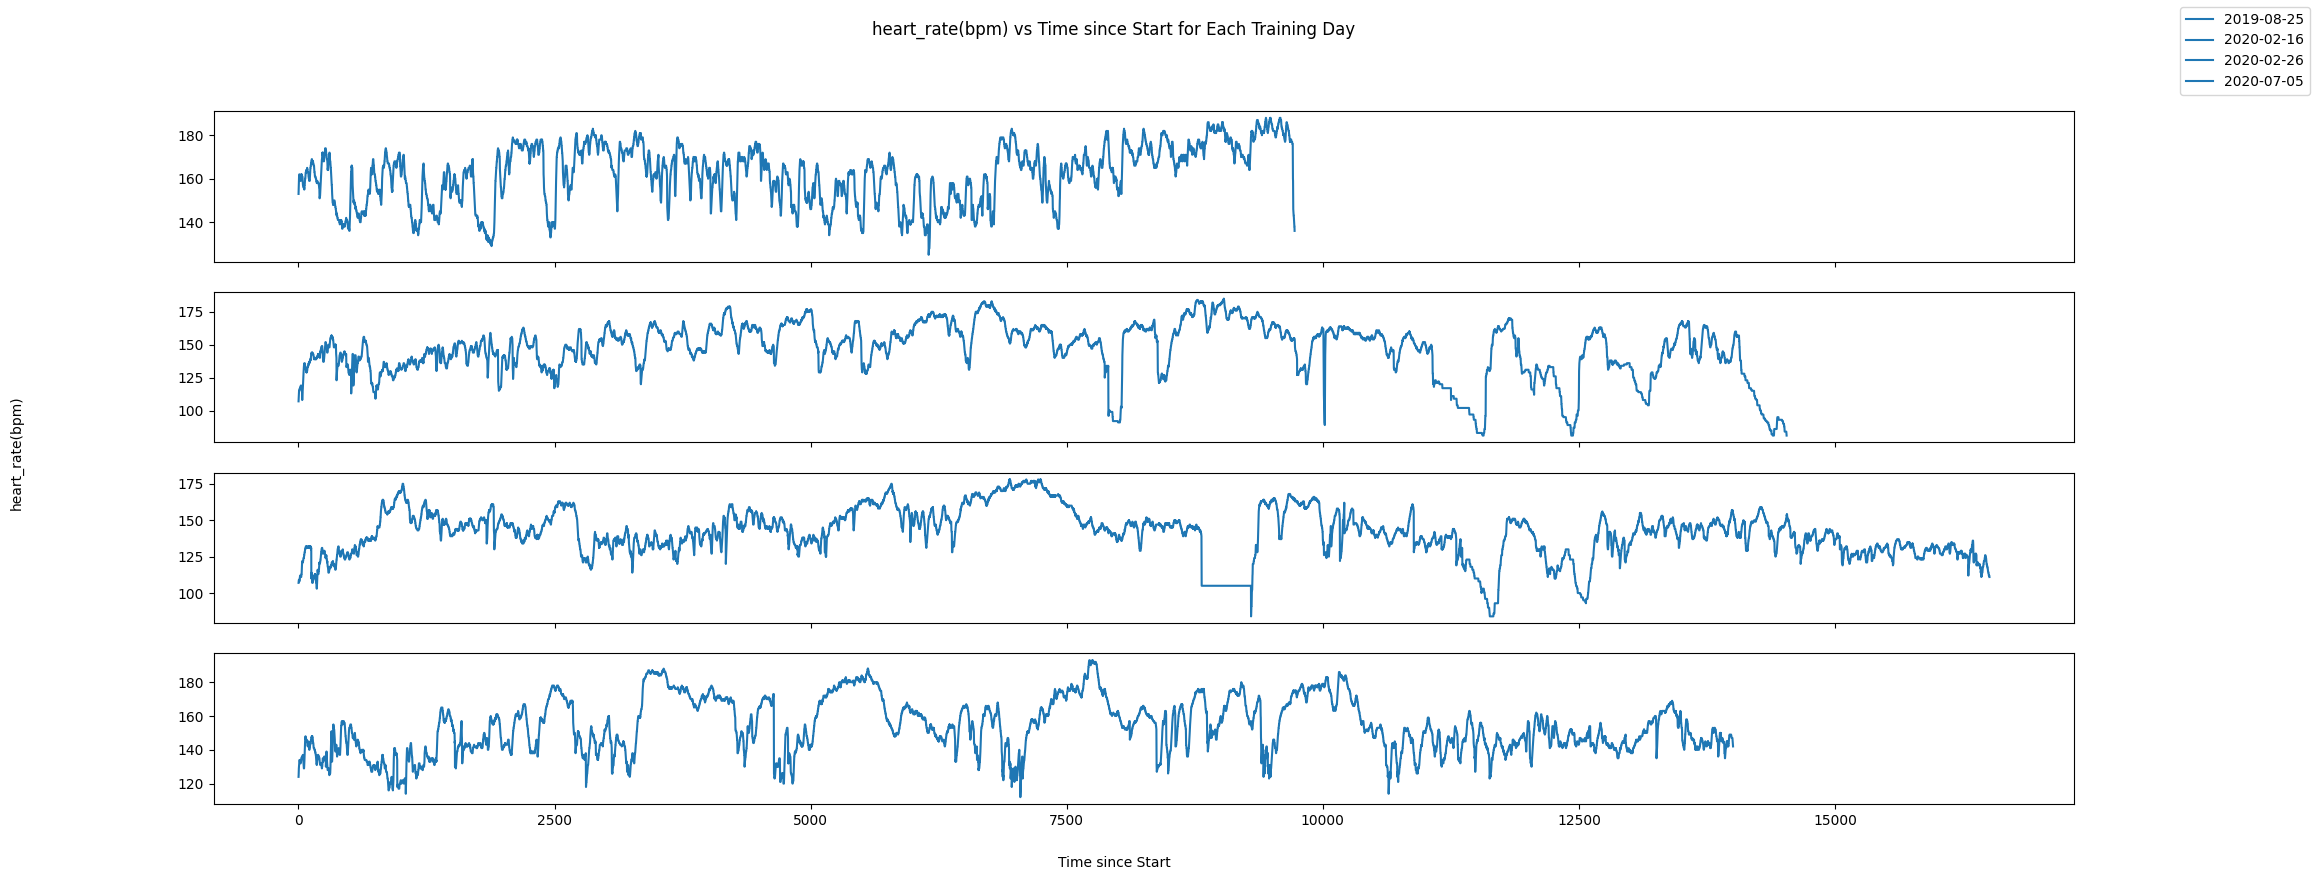

In [13]:
plot_data_vs_time('heart_rate(bpm)')

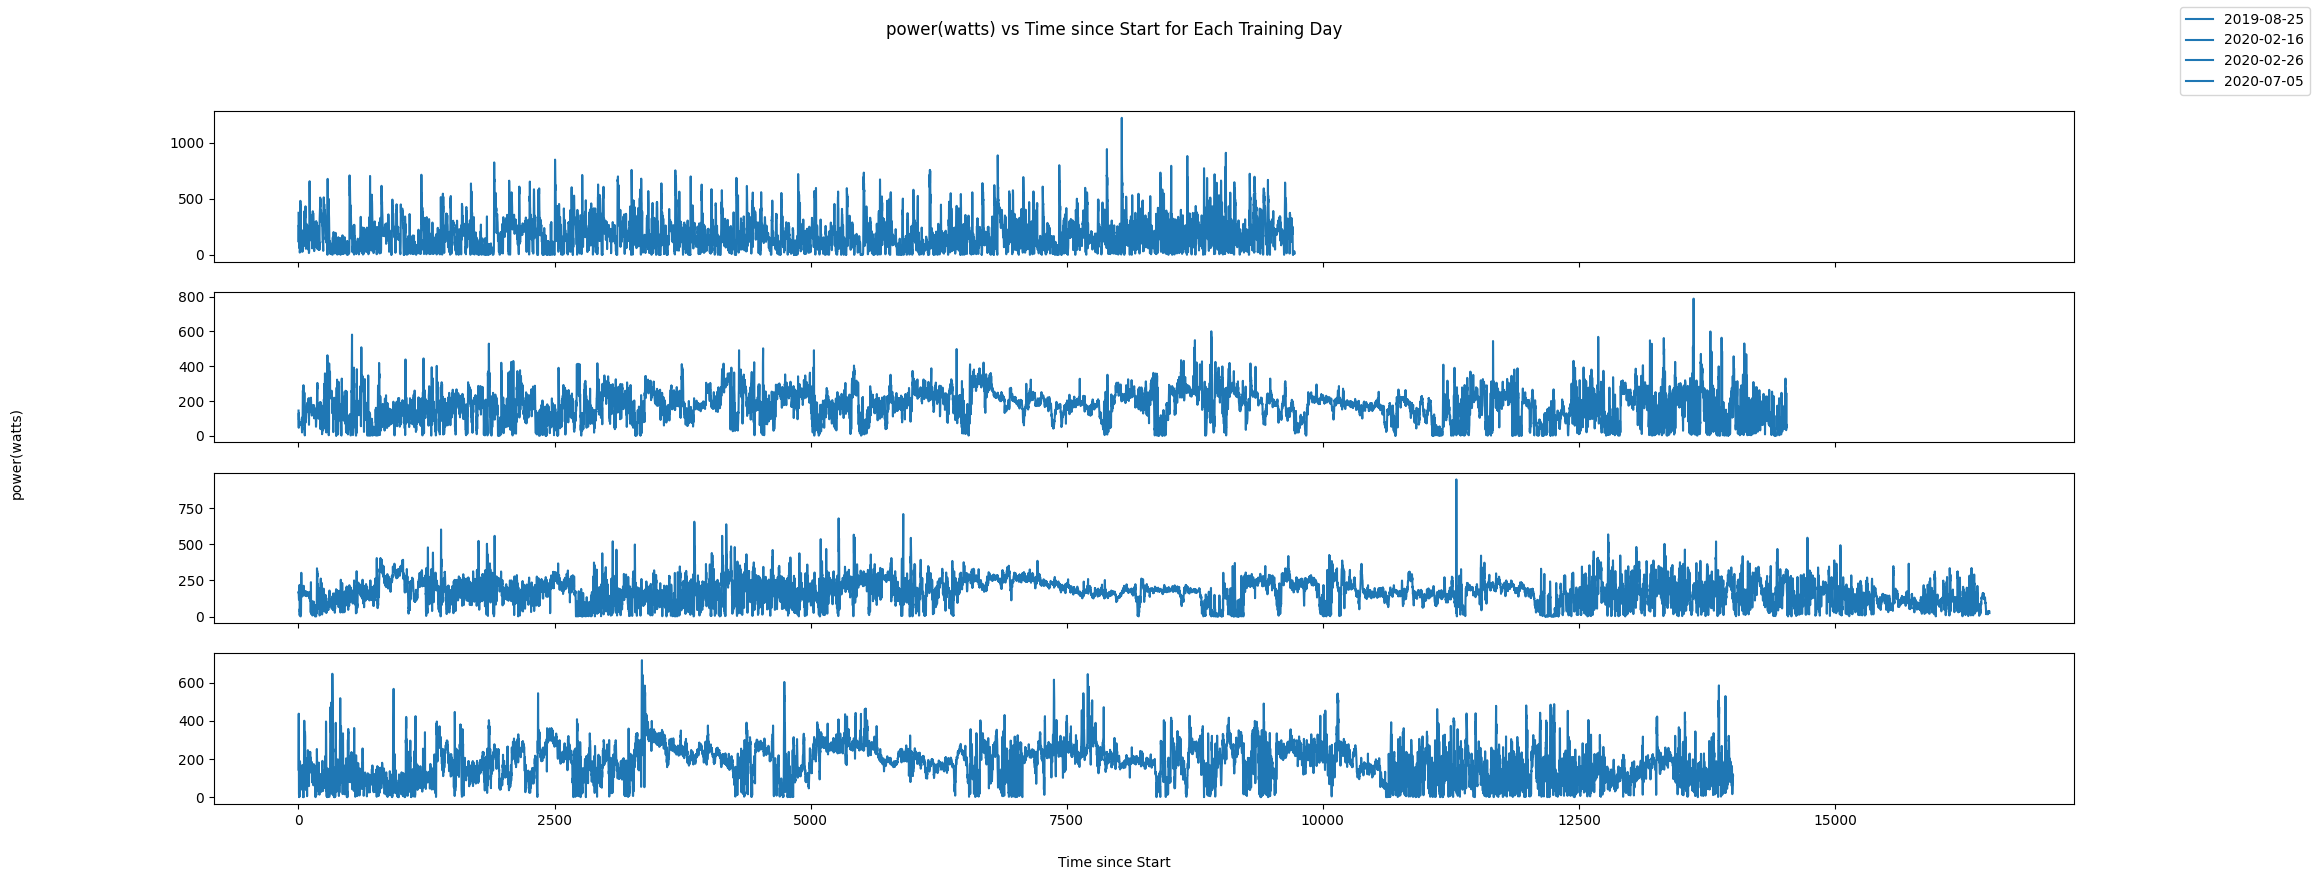

In [14]:
plot_data_vs_time('power(watts)')

Come ultima cosa vengono rimosse quelle feature inutilizzate per l'analisi.
- `left_right_balance`: non è più necessaria poiché abbiamo calcolato `left_power` e `right_power`
- `left_power_phase_peak`: non è necessario il picco se abbiamo il valore istantaneo
- `right_power_phase_peak`: come sopra
- `left_power_phase`: (***ANCORA DA CALCOLARE***)
- `right_power_phase`: (***ANCORA DA CALCOLARE***)

In [15]:
combined_df = combined_df.drop(['left_power_phase(degrees)',
                            'left_power_phase_peak(degrees)',
                            'right_power_phase(degrees)',
                            'right_power_phase_peak(degrees)',
                            'left_right_balance'], axis=1)

In [16]:
combined_df.describe()

,distance(m),altitude(m),speed(m/s),power(watts),heart_rate(bpm),temperature(C),cadence(rpm),accumulated_power(watts),left_pco(mm),right_pco(mm),hr_zone,pwr_zone,altitude_diff(m),distance_diff(m),slope_percent,avg_power(watts),power_left(watts),power_right(watts),time_since_start(s)
count,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,5.476200e+04,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000
mean,64521.249793,251.621197,8.534468,175.624776,149.600179,19.868558,85.472225,1.270082e+06,-4.066305,-0.947792,3.170447,3.031810,-0.000475,2.393728,1.804252,175.212154,50.339359,49.660641,7069.114824
std,37980.804573,264.867983,3.380105,101.489122,18.660800,8.151409,16.624331,7.952214e+05,5.974655,4.171117,1.549633,2.229843,1.129546,1030.614963,4.597845,87.319822,11.603826,11.603826,4288.059921
min,6.790000,3.200000,0.370000,1.000000,81.000000,5.000000,4.000000,3.340000e+02,-123.000000,-98.000000,1.000000,1.000000,-115.000000,-151785.510000,-52.238806,1.000000,0.000000,0.000000,1.000000
25%,33442.332500,57.000000,5.750000,105.000000,139.000000,14.000000,81.000000,5.707108e+05,-7.000000,-3.000000,2.000000,1.000000,0.000000,5.780000,0.000000,113.000000,48.000000,47.000000,3423.000000
50%,63902.350000,118.400000,9.070000,175.000000,150.000000,16.000000,89.000000,1.232008e+06,-5.000000,-1.000000,3.000000,2.000000,0.000000,9.100000,0.000000,173.000000,50.000000,50.000000,6846.000000
75%,91821.615000,406.600000,10.990000,236.000000,163.000000,30.000000,95.000000,1.952738e+06,-2.000000,1.000000,4.000000,5.000000,0.200000,11.100000,3.327787,230.000000,53.000000,52.000000,10449.750000
max,151811.360000,1112.800000,18.140000,1224.000000,193.000000,34.000000,146.000000,2.871844e+06,123.000000,126.000000,7.000000,7.000000,46.800000,6205.460000,62.639821,856.000000,100.000000,100.000000,16507.000000


In [17]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54762 entries, 2019-08-25 12:05:10 to 2020-07-05 10:23:29
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance(m)               54762 non-null  float64
 1   altitude(m)               54762 non-null  float64
 2   speed(m/s)                54762 non-null  float64
 3   power(watts)              54762 non-null  int64  
 4   heart_rate(bpm)           54762 non-null  int64  
 5   temperature(C)            54762 non-null  int64  
 6   cadence(rpm)              54762 non-null  int64  
 7   accumulated_power(watts)  54762 non-null  int64  
 8   left_pco(mm)              54762 non-null  int64  
 9   right_pco(mm)             54762 non-null  int64  
 10  hr_zone                   54762 non-null  int64  
 11  pwr_zone                  54762 non-null  int64  
 12  altitude_diff(m)          54762 non-null  float64
 13  distance_diff(m)          

# Data Visualization

Di seguito sono riportati i grafici che mostrano la distribuzione delle features. Per avere una visione più chiara si è deciso di dividere le misurazioni in base all'allenamento.

In [18]:
def plot_params_per_training(params):
    grouped_df = combined_df.groupby(combined_df.index.date)

    fig, axs = plt.subplots(nrows=len(grouped_df), figsize=(21, 10), sharex=True)

    for i, (date, data) in enumerate(grouped_df):
        axs[i].set_title(str(date))

        for param in params:
            axs[i].plot(data["time_since_start(s)"], data[param], label=param)

        axs[i].legend()
        axs[i].grid(True)

    plt.xlabel("time_since_start")
    plt.suptitle("Data vs Time since Start for Each Training Day")
    plt.show()

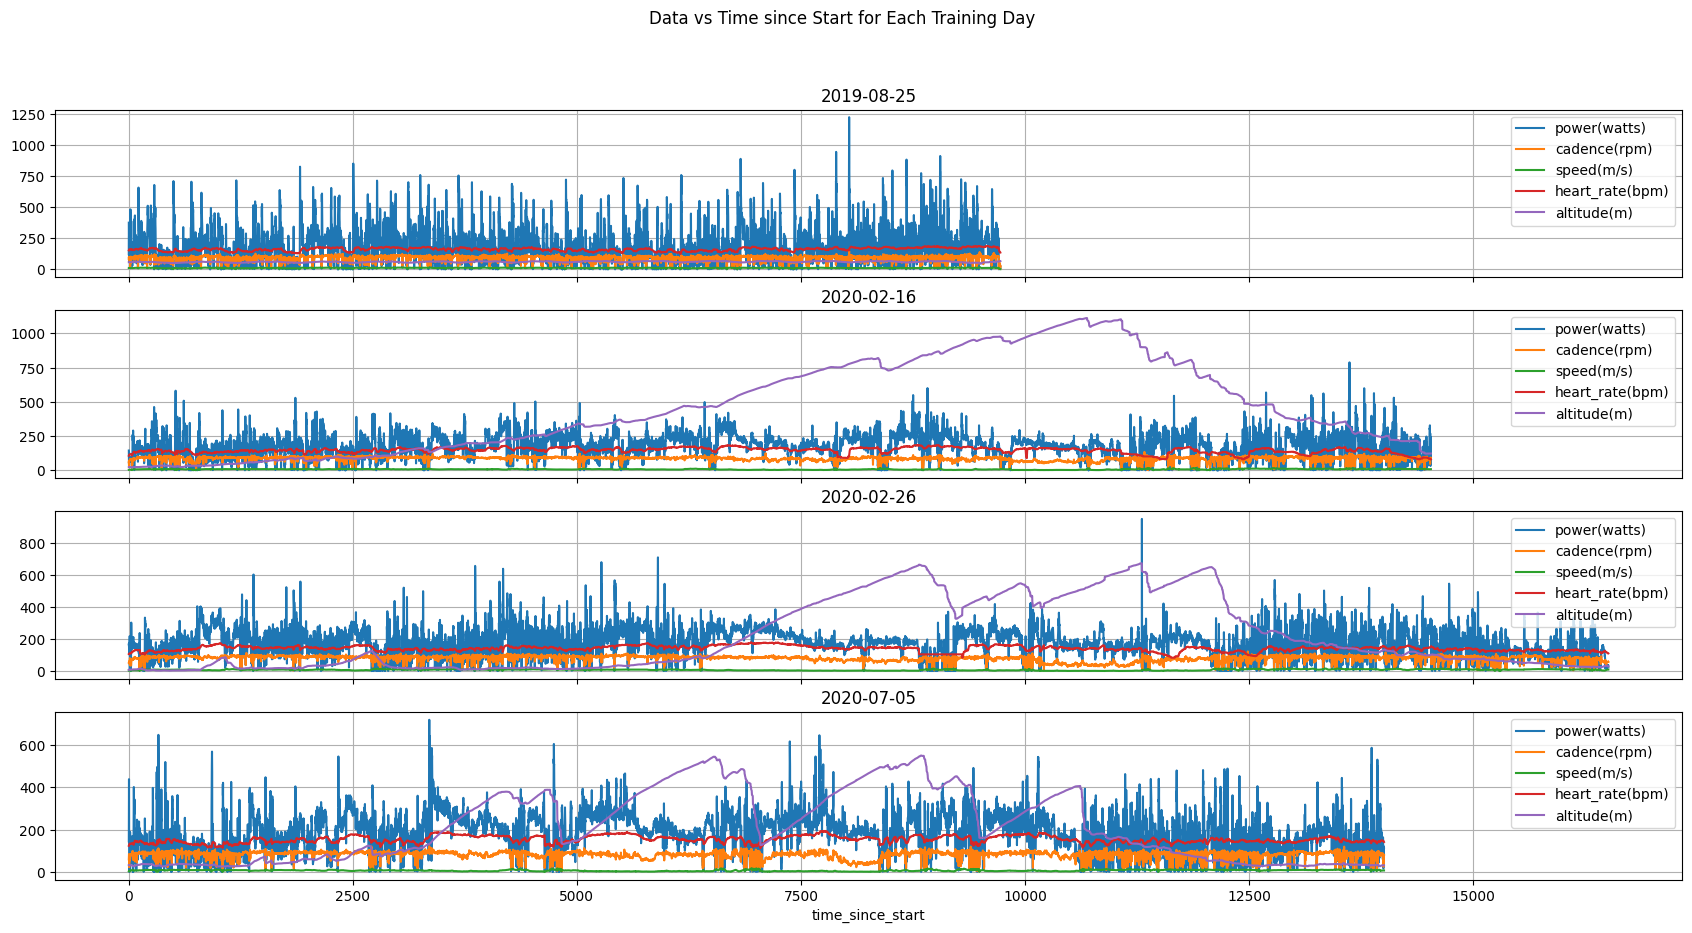

In [19]:
plot_params_per_training(['power(watts)', 'cadence(rpm)', 'speed(m/s)', 'heart_rate(bpm)', 'altitude(m)'])

# Previsioni

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Di seguito sono riportati i modelli utilizzati per le previsioni. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Abbiamo deciso di provare diversi modelli per capire quale fosse il migliore per il nostro dataset. In particolare abbiamo provato i seguenti modelli:
- Modelli lineari
    - *Linear Regression*
    - *Ridge Regression*
    - *Lasso Regression*
    - *Elastic Net*
- Modelli Kernel
    - *KernelRidge*
- Modelli ad albero
    - *Decision Tree Regressor*
    - *Random Forest Regressor*
    - *XGBoost Regressor*
    - *LightGBM Regressor*
    
Per ciascuno di essi abbiamo fatto un tuning degli iperparametri per ottenere i migliori risultati possibili.

In [21]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Definizione dei modelli

Per l'addestramento abbiamo deciso di utilizzare la cross validation con 5 fold. Inoltre abbiamo deciso di aggregare tutte le pipeline in un unico dizionario per poterle richiamare più facilmente.
Con il metodo `get_pipe_grid(type)` si restituisce l'opportuna pipeline e il dizionario di iperparametri da utilizzare per il tuning. Il parametro `type` può assumere i seguenti valori:
- `linear`: modelli lineari
- `kernel`: modelli kernel
- `tree`: modelli ad albero

In [22]:
def get_pipe_grid(type):
    pipelines = {
        "linear": {
            "pipe": Pipeline([
                ("poly", PolynomialFeatures(include_bias=False)),
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "poly__degree": [3, 4, 5],
                "std": [StandardScaler()],
            },
            "grid_regressors": [
                {
                    "regressor": [LinearRegression()],
                },
                {
                    "regressor": [ElasticNet()],
                    "regressor__alpha": [0.01, 0.1, 1],
                    "regressor__l1_ratio": [0.0, 0.5, 1.0],
                },
            ]
        },
        "kernel": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor": [KernelRidge()],
                'regressor__alpha': [0.1],
            },
            "grid_regressors": [
                {
                    "regressor__kernel": ["poly"],
                    'regressor__degree': [3],
                },
                {
                    "regressor__kernel": ["rbf"],
                    "regressor__gamma": [0.1],
                }
            ]
        },
        "tree": {
            "pipe": Pipeline([
                ("std", None),
                ("regressor", None)
            ]),
            "grid_common": {
                "std": [StandardScaler()],
                "regressor__max_depth": [5,10,15],
            },
            "grid_regressors": [
                {
                    "regressor": [DecisionTreeRegressor()],
                },
                {
                    "regressor": [RandomForestRegressor()],
                    "regressor__n_estimators": [100,1000],
                },
                {
                    "regressor": [LGBMRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                },
                {
                    "regressor": [XGBRegressor()],
                    "regressor__n_estimators": [100,1000],
                    "regressor__learning_rate": [0.01,0.1],
                }
            ]
        }
    }
    return pipelines[type]["pipe"], [dict(pipelines[type]["grid_common"], **params) for params in pipelines[type]["grid_regressors"]]

Attraverso il metodo `get_trained_model(type, X_train, y_train, randomized)` ci consente di restituire il miglior modello addestrato fra tutti quelli provati attraverso la grid/randomized search.
Il metodo ha i seguenti parametri:
- `type`: tipo di modello da addestrare, i valori assunti sono gli stessi del metodo precedente. Serve infatti per richiamare il metodo `get_pipe_grid(type)`
- `X_train`: training set
- `y_train`: target set
- `randomized`: booleano che indica se utilizzare la *grid search* o la *randomized search*

In [23]:
def get_trained_model(type, X_train, y_train):
    pipe, grid = get_pipe_grid(type)
    model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
    model.fit(X_train, y_train)
    return model

In [24]:
import utilities
from utilities import print_eval


## Previsione battito

In questa sezione vengono riportati i modelli utilizzati per la previsione del battito cardiaco. Per ogni modello sono riportati i parametri utilizzati e i risultati ottenuti.
Come prima cosa costruiamo il training set `X_hr` droppando dal dataset i parametri non necessari.
In particolare abbiamo deciso di droppare, fra le altre, anche `hr_zone`, questo perché in una prima versione del codice, i modelli addestrati, come ci si poteva aspettare, davano troppa importanza a questa feature, trascurando le altre. Essendoci una troppo alta correlazione fra `hr_zone` e `heart_rate(bmp)`, abbiamo deciso di droppare `hr_zone` per evitare questo problema.

In [25]:
X_hr = combined_df.drop(['heart_rate(bpm)','distance(m)','altitude(m)','speed(m/s)','avg_power(watts)','time_since_start(s)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_hr = combined_df['heart_rate(bpm)']
X_train, X_val, y_train, y_val = train_test_split(X_hr, y_hr, test_size=1/3, random_state=42)

### Regressione lineare

Con modelli di regressione lineare si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto tramite una Grid Search.

In [26]:
liner_models_gs = get_trained_model('linear', X_train, y_train)
linear_models_gs_res = pd.DataFrame(liner_models_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, liner_models_gs)
linear_models_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:        279.1
       Relative error:     9.01867%
R-squared coefficient:       0.1946


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.521e+05, tolerance: 1.274e+03
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regressor,param_std,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.674433,0.058109,0.004910,0.000652,4,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,1.0,"{'poly__degree': 4, 'regressor': ElasticNet(al...",0.196717,0.198262,0.199053,0.208233,0.191149,0.198683,0.005516,1
22,1.445476,0.169261,0.006224,0.001965,5,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,0.5,"{'poly__degree': 5, 'regressor': ElasticNet(al...",0.191865,0.191715,0.194417,0.198444,0.186775,0.192643,0.003813,2
21,1.342168,0.037231,0.007341,0.002417,5,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,0.0,"{'poly__degree': 5, 'regressor': ElasticNet(al...",0.190728,0.190528,0.193583,0.201357,0.185606,0.192360,0.005178,3
0,0.020858,0.002367,0.003305,0.000505,3,LinearRegression(),StandardScaler(),NaN,NaN,"{'poly__degree': 3, 'regressor': LinearRegress...",0.192156,0.192463,0.194615,0.181934,0.187833,0.189800,0.004507,4
13,0.907703,0.182074,0.006779,0.003301,4,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,0.5,"{'poly__degree': 4, 'regressor': ElasticNet(al...",0.188968,0.188909,0.191921,0.185578,0.183601,0.187796,0.002903,5
12,1.009235,0.134327,0.006618,0.002739,4,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,0.0,"{'poly__degree': 4, 'regressor': ElasticNet(al...",0.187221,0.187096,0.190378,0.179044,0.181757,0.185099,0.004103,6
5,0.429992,0.051705,0.004043,0.001107,3,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,1.0,"{'poly__degree': 3, 'regressor': ElasticNet(al...",0.186138,0.186102,0.188729,0.180208,0.180353,0.184306,0.003422,7
26,0.199257,0.064335,0.008850,0.003955,5,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.1,1.0,"{'poly__degree': 5, 'regressor': ElasticNet(al...",0.185953,0.185286,0.188119,0.171755,0.180870,0.182396,0.005819,8
4,0.296657,0.104379,0.003913,0.000373,3,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.01,0.5,"{'poly__degree': 3, 'regressor': ElasticNet(al...",0.183777,0.183661,0.186558,0.180344,0.177456,0.182359,0.003144,9
17,0.124646,0.099860,0.006413,0.001245,4,"ElasticNet(alpha=0.01, l1_ratio=1.0)",StandardScaler(),0.1,1.0,"{'poly__degree': 4, 'regressor': ElasticNet(al...",0.184316,0.183986,0.186779,0.176227,0.178769,0.182016,0.003897,10


### Regressione con funzioni kernel

Con modelli di regressione con funzioni Kernel si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto con una Grid Search.

In [27]:
'''
krm_gs = get_trained_model('kernel', X_train, y_train)
krm_gs_res = pd.DataFrame(krm_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, krm_gs)
krm_gs_res
'''

'\nkrm_gs = get_trained_model(\'kernel\', X_train, y_train)\nkrm_gs_res = pd.DataFrame(krm_gs.cv_results_).sort_values("mean_test_score", ascending=False)\nprint_eval(X_val, y_val, krm_gs)\nkrm_gs_res\n'

### Alberi di regressione

Con modelli di regressione ad albero si sono ottenuti i seguenti risultati
- Mean squared error:
- Relative error:
- R2:

tramite il miglior modello () ottenuto con una Grid Search.

In [28]:
tree_gs = get_trained_model('tree', X_train, y_train)
tree_gs_res = pd.DataFrame(tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
print_eval(X_val, y_val, tree_gs, tree=True)
tree_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


   Mean squared error:       267.88
    RMSPE:      0.13398
R-squared coefficient:      0.22697


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__max_depth,param_std,param_regressor__n_estimators,param_regressor__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,5.422264,1.173990,0.024655,0.024550,"XGBRegressor(base_score=None, booster=None, ca...",5,StandardScaler(),1000,0.01,"{'regressor': XGBRegressor(base_score=None, bo...",0.222415,0.224944,0.235087,0.236961,0.221599,0.228201,0.006509,1
10,26.325239,6.302156,0.028685,0.003251,LGBMRegressor(),5,StandardScaler(),1000,0.01,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.220813,0.225007,0.236420,0.237994,0.220657,0.228178,0.007552,2
27,0.836374,0.297079,0.004603,0.002226,"XGBRegressor(base_score=None, booster=None, ca...",5,StandardScaler(),100,0.1,"{'regressor': XGBRegressor(base_score=None, bo...",0.221772,0.224091,0.235443,0.238145,0.220042,0.227899,0.007425,3
15,1.638590,0.688857,0.005207,0.000511,LGBMRegressor(),5,StandardScaler(),100,0.1,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.219837,0.223932,0.235589,0.238109,0.220626,0.227618,0.007702,4
4,10.051895,0.960398,0.308554,0.069988,RandomForestRegressor(),5,StandardScaler(),1000,NaN,"{'regressor': RandomForestRegressor(), 'regres...",0.218634,0.224007,0.232466,0.237971,0.218400,0.226295,0.007755,5
3,0.956793,0.037893,0.026735,0.003307,RandomForestRegressor(),5,StandardScaler(),100,NaN,"{'regressor': RandomForestRegressor(), 'regres...",0.218126,0.223641,0.232560,0.237910,0.217830,0.226013,0.007990,6
12,30.703688,2.445930,0.031580,0.004334,LGBMRegressor(),10,StandardScaler(),1000,0.01,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.217667,0.221940,0.232983,0.237042,0.219168,0.225760,0.007785,7
14,24.610961,4.885328,0.028829,0.004076,LGBMRegressor(),15,StandardScaler(),1000,0.01,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.216455,0.222311,0.232834,0.236185,0.219766,0.225510,0.007653,8
17,2.039993,0.140428,0.007409,0.001243,LGBMRegressor(),10,StandardScaler(),100,0.1,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.216040,0.221188,0.232362,0.237173,0.218397,0.225032,0.008256,9
19,2.239880,0.596382,0.007322,0.001302,LGBMRegressor(),15,StandardScaler(),100,0.1,"{'regressor': LGBMRegressor(), 'regressor__lea...",0.215705,0.220645,0.231597,0.236653,0.219719,0.224864,0.007905,10


### Confronto fra modelli

Di seguito è riportato un confronto fra i modelli per la previsione del battito. Come si può vedere, i migliori risultati sono ottenuti tramite i modelli ad Albero.
Questo perché ottengono R2 molto prossimi a 1, errore relativo molto basso e tempi di addestamento molto simili a quelli dei modelli lineari.

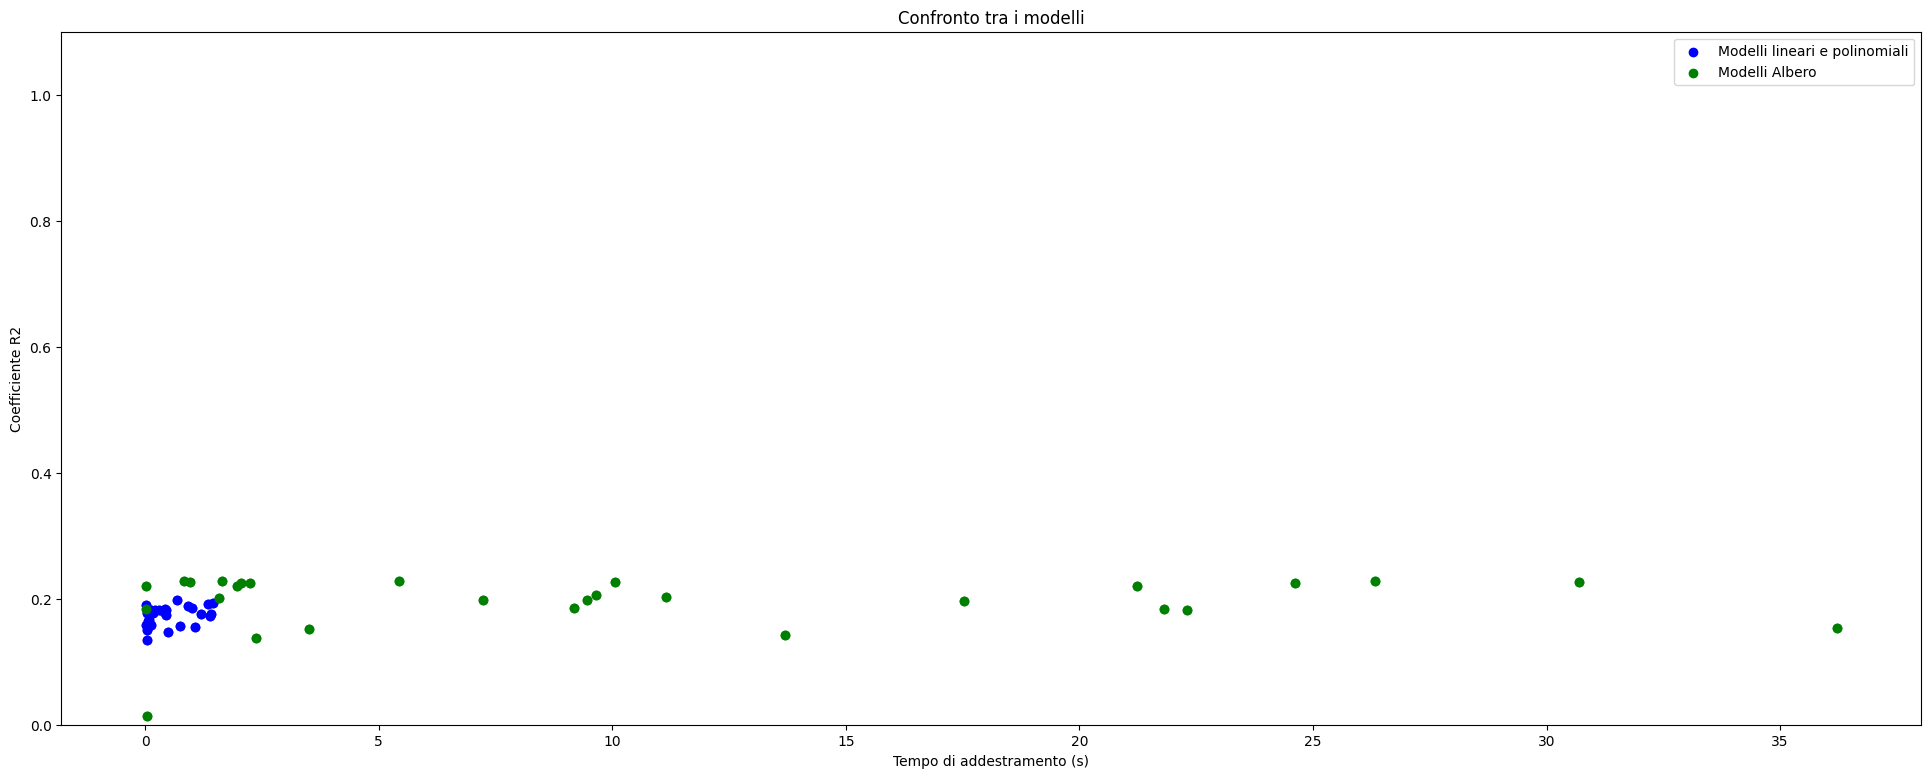

In [29]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_models_gs_res, linear_models_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')
'''
krm_models = pd.concat([krm_gs_res, krm_gs_res], axis=0)
scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')
'''
tree_models = pd.concat([tree_gs_res, tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()


### test predizione

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


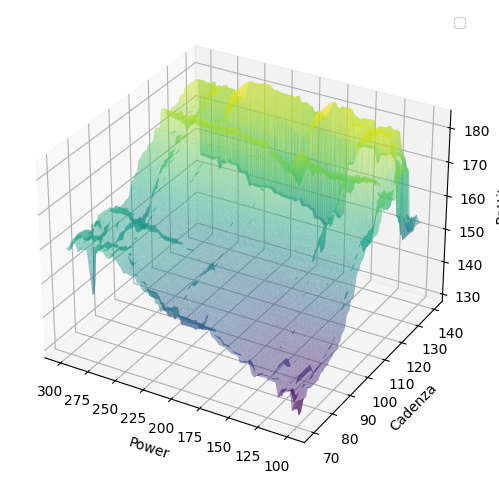

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_model_on_data(X, y, model=None):
    if X.shape[1] != 2:
        raise ValueError("La funzione supporta solo dati bidimensionali (due feature per campione).")
    
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(111, projection='3d')
    power = X[:, 0]
    cadenza = X[:, 1]
    battito = y
    #ax.scatter(power, cadenza,battito, c='blue', linewidth=0.5)
    
    if model is not None:
        xlim_power, ylim_cadenza = plt.xlim(), plt.ylim()
        line_power = np.linspace(100, 300, 100)
        line_cadenza = np.linspace(70, 140, 100)
        combined = np.array(np.meshgrid(line_power, line_cadenza)).T.reshape(-1, 2)
        predicted = model.predict(combined)
        ax.plot_trisurf(combined[:, 0], combined[:, 1], predicted, alpha=0.5, cmap='viridis', linewidth=0.2)
        
    ax.set_xlabel('Power')
    ax.set_ylabel('Cadenza')
    ax.set_zlabel('Battito')
    ax.invert_xaxis()
    plt.grid()
    plt.legend()
    plt.show()  # Add this line to display the plot.

# Assuming you have X_val and y_val defined and tree_gs is the trained model.
X_val_array = X_val.to_numpy()
plot_model_on_data(X_val_array, y_val, tree_gs)


In [31]:
pd.DataFrame({'Feature': X_hr.columns, 'Weight': tree_gs.best_estimator_.named_steps['regressor'].feature_importances_})

,Feature,Weight
0,power(watts),0.700373
1,cadence(rpm),0.299627


In [32]:
tree_gs.predict(np.array([280, 110]).reshape(1, -1))

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([169.41183], dtype=float32)

### Reti neurali

Abbiamo deciso di provare anche le reti neurali per la previsione del battito. In particolare abbiamo provato due tipi di reti neurali:
- *Multi Layer Perceptron* (sklearn)
- *Adam Neural Network* (keras)

In [33]:
'''
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)
'''

'\nfrom sklearn.neural_network import MLPRegressor\n\npipe = Pipeline([\n    ("std", StandardScaler()),\n    ("regressor", MLPRegressor())\n])\n\ngrid = {\n    "regressor__hidden_layer_sizes": [(256, 256)],\n    "regressor__activation": ["relu"],\n    "regressor__max_iter": [2000],\n    "regressor__batch_size": [128],\n    "regressor__alpha": [0.01]\n\n}\n\nmodel = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)\nmodel.fit(X_train, y_train)\nprint_eval(X_val, y_val, model)\n'

In [34]:
#pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

In [35]:
#pd.DataFrame({'Feature': X_hr.columns, 'Weight': model.best_estimator_.named_steps['regressor'].coefs_[0].mean(axis=1)})

In [36]:
'''
import tensorflow as tf
import keras_tuner  as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} )
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
'''

"\nimport tensorflow as tf\nimport keras_tuner  as kt\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras import layers\n\nconfig = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} )\nsess = tf.compat.v1.Session(config=config) \ntf.compat.v1.keras.backend.set_session(sess)\n"

In [37]:
'''
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=X_train.shape[1:]))
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    for i in range(num_layers):
        hp_units = hp.Int(f'units_{i}', min_value=32, max_value=1024, step=32)
        model.add(layers.Dense(units=hp_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1,0.01,0.001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mean_absolute_error',metrics=['mean_absolute_error'])

    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=5,
                     directory='tensorflow',
                     project_name='garmin_analysis8')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)

tuner.search(X_train, y_train, epochs=10,validation_split=1/3, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connectedlayer is {best_hps.get('num_layers')} 
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_split=1/3)
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=1/3)
eval_result = hypermodel.evaluate(X_val, y_val)
print("[test loss, test mae]:", eval_result)
'''

'\ndef model_builder(hp):\n    model = tf.keras.Sequential()\n    model.add(layers.Flatten(input_shape=X_train.shape[1:]))\n    num_layers = hp.Int(\'num_layers\', min_value=1, max_value=5, step=1)\n    for i in range(num_layers):\n        hp_units = hp.Int(f\'units_{i}\', min_value=32, max_value=1024, step=32)\n        model.add(layers.Dense(units=hp_units, activation=\'relu\'))\n    model.add(layers.Dense(1, activation=\'linear\'))\n    hp_learning_rate = hp.Choice(\'learning_rate\', values=[0.1,0.01,0.001])\n\n    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=\'mean_absolute_error\',metrics=[\'mean_absolute_error\'])\n\n    return model\n\n\ntuner = kt.Hyperband(model_builder,\n                     objective=\'val_mean_absolute_error\',\n                     max_epochs=100,\n                     factor=5,\n                     directory=\'tensorflow\',\n                     project_name=\'garmin_analysis8\')\n\nstop_early = tf.keras.callbacks.

In [38]:
#hypermodel.summary()

### test predizione

In [39]:
#hypermodel.predict(np.array([0,0,9,100,100,0,30]).reshape(1, -1))

## Previsione Potenza

La previsione della potenza è del tutto identica a quella fatta per il battito. La differenza sta nel fatto che il training set è differente. In particolare, per la previsione della potenza, abbiamo deciso di droppare anche `power_zone` per lo stesso motivo per cui abbiamo droppato `hr_zone` per la previsione del battito.

In [40]:
X_watt = combined_df.drop(['power(watts)','distance(m)','altitude(m)','speed(m/s)','avg_power(watts)','time_since_start(s)','slope_percent','temperature(C)','hr_zone','pwr_zone','altitude_diff(m)','distance_diff(m)','left_pco(mm)','right_pco(mm)','power_left(watts)','power_right(watts)','accumulated_power(watts)'], axis=1)
y_watt = combined_df['avg_power(watts)']
X_train, X_val, y_train, y_val = train_test_split(X_watt, y_watt, test_size=1/3, random_state=42)

### Regressione con modelli lineari e polinomiali

In [41]:
linear_gs = get_trained_model('linear', X_train, y_train)
print_eval(X_val, y_val, linear_gs)
linear_gs_res=pd.DataFrame(linear_gs.cv_results_).sort_values("mean_test_score", ascending=False)
linear_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


   Mean squared error:       5876.5
       Relative error:    98.17961%
R-squared coefficient:       0.2491


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regressor,param_std,param_regressor__alpha,param_regressor__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.025184,0.001500,0.002907,0.000668,5,LinearRegression(),StandardScaler(),NaN,NaN,"{'poly__degree': 5, 'regressor': LinearRegress...",0.260573,0.270244,0.262750,0.261367,0.273398,0.265667,0.005170,1
1,0.016754,0.001117,0.001915,0.000378,4,LinearRegression(),StandardScaler(),NaN,NaN,"{'poly__degree': 4, 'regressor': LinearRegress...",0.258700,0.269741,0.258724,0.257633,0.267296,0.262419,0.005055,2
0,0.013468,0.001051,0.002104,0.000198,3,LinearRegression(),StandardScaler(),NaN,NaN,"{'poly__degree': 3, 'regressor': LinearRegress...",0.253029,0.262133,0.252938,0.251340,0.259459,0.255780,0.004225,3
23,1.172097,0.232751,0.004930,0.000640,5,ElasticNet(),StandardScaler(),0.01,1.0,"{'poly__degree': 5, 'regressor': ElasticNet(),...",0.249611,0.259690,0.252204,0.249078,0.257668,0.253650,0.004288,4
14,0.769704,0.078592,0.005334,0.000652,4,ElasticNet(),StandardScaler(),0.01,1.0,"{'poly__degree': 4, 'regressor': ElasticNet(),...",0.246621,0.257498,0.249339,0.246098,0.256575,0.251226,0.004879,5
5,0.316294,0.065133,0.003121,0.000204,3,ElasticNet(),StandardScaler(),0.01,1.0,"{'poly__degree': 3, 'regressor': ElasticNet(),...",0.244427,0.255740,0.247013,0.243883,0.255274,0.249268,0.005205,6
26,0.922325,0.242828,0.004921,0.001158,5,ElasticNet(),StandardScaler(),0.1,1.0,"{'poly__degree': 5, 'regressor': ElasticNet(),...",0.243332,0.254883,0.246328,0.243260,0.253223,0.248205,0.004929,7
22,1.274724,0.222448,0.007939,0.004251,5,ElasticNet(),StandardScaler(),0.01,0.5,"{'poly__degree': 5, 'regressor': ElasticNet(),...",0.243111,0.254306,0.246410,0.243049,0.253246,0.248024,0.004863,8
13,0.812185,0.152525,0.005121,0.000868,4,ElasticNet(),StandardScaler(),0.01,0.5,"{'poly__degree': 4, 'regressor': ElasticNet(),...",0.242523,0.253294,0.245531,0.242004,0.252386,0.247148,0.004810,9
17,0.657261,0.063558,0.009876,0.005023,4,ElasticNet(),StandardScaler(),0.1,1.0,"{'poly__degree': 4, 'regressor': ElasticNet(),...",0.242441,0.253623,0.245335,0.241780,0.252226,0.247081,0.004939,10


### Regressione con funzioni kernel

In [42]:
'''
kernel_gs = get_trained_model('kernel', X_train, y_train)
print_eval(X_val, y_val, kernel_gs)
kernel_gs_res=pd.DataFrame(kernel_gs.cv_results_).sort_values("mean_test_score", ascending=False)
kernel_gs_res
'''

'\nkernel_gs = get_trained_model(\'kernel\', X_train, y_train)\nprint_eval(X_val, y_val, kernel_gs)\nkernel_gs_res=pd.DataFrame(kernel_gs.cv_results_).sort_values("mean_test_score", ascending=False)\nkernel_gs_res\n'

### Regressione con alberi

In [43]:
watt_tree_gs = get_trained_model('tree', X_train, y_train)
print_eval(X_val, y_val, watt_tree_gs, tree=True)
watt_tree_gs_res=pd.DataFrame(watt_tree_gs.cv_results_).sort_values("mean_test_score", ascending=False)
watt_tree_gs_res

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 36508, number of used features: 2
[LightGBM] [Info] Start training from score 175.207023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__max_depth,param_std,param_regressor__n_estimators,param_regressor__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,28.107243,2.661677,0.033901,0.005065,"LGBMRegressor(learning_rate=0.01, max_depth=10...",10,StandardScaler(),1000,0.01,{'regressor': LGBMRegressor(learning_rate=0.01...,0.293660,0.302718,0.293712,0.285217,0.295715,0.294205,0.005587,1
14,25.899978,1.302801,0.035441,0.011237,"LGBMRegressor(learning_rate=0.01, max_depth=10...",15,StandardScaler(),1000,0.01,{'regressor': LGBMRegressor(learning_rate=0.01...,0.293857,0.303101,0.293598,0.284759,0.295498,0.294163,0.005840,2
15,1.295949,0.326880,0.005910,0.000667,"LGBMRegressor(learning_rate=0.01, max_depth=10...",5,StandardScaler(),100,0.1,{'regressor': LGBMRegressor(learning_rate=0.01...,0.293888,0.300372,0.294412,0.284932,0.296246,0.293970,0.005061,3
10,21.410739,4.442905,0.023855,0.000651,"LGBMRegressor(learning_rate=0.01, max_depth=10...",5,StandardScaler(),1000,0.01,{'regressor': LGBMRegressor(learning_rate=0.01...,0.293355,0.300693,0.293775,0.285362,0.296146,0.293866,0.004988,4
19,2.071367,0.581927,0.007442,0.000883,"LGBMRegressor(learning_rate=0.01, max_depth=10...",15,StandardScaler(),100,0.1,{'regressor': LGBMRegressor(learning_rate=0.01...,0.292460,0.303014,0.293031,0.284595,0.295873,0.293795,0.005938,5
27,0.610758,0.087227,0.003109,0.000381,"XGBRegressor(base_score=None, booster=None, ca...",5,StandardScaler(),100,0.1,"{'regressor': XGBRegressor(base_score=None, bo...",0.294629,0.301006,0.293619,0.286490,0.292773,0.293703,0.004628,6
17,1.700551,0.031785,0.007106,0.000968,"LGBMRegressor(learning_rate=0.01, max_depth=10...",10,StandardScaler(),100,0.1,{'regressor': LGBMRegressor(learning_rate=0.01...,0.292915,0.301441,0.293068,0.284598,0.295101,0.293424,0.005392,7
22,5.284621,0.337255,0.010516,0.002528,"XGBRegressor(base_score=None, booster=None, ca...",5,StandardScaler(),1000,0.01,"{'regressor': XGBRegressor(base_score=None, bo...",0.293117,0.301604,0.293881,0.284124,0.293669,0.293279,0.005543,8
6,15.224673,1.456689,0.527691,0.048180,RandomForestRegressor(),10,StandardScaler(),1000,NaN,"{'regressor': RandomForestRegressor(), 'regres...",0.287391,0.295314,0.286600,0.275784,0.290905,0.287199,0.006485,9
5,1.402022,0.056558,0.055512,0.004284,RandomForestRegressor(),10,StandardScaler(),100,NaN,"{'regressor': RandomForestRegressor(), 'regres...",0.288982,0.294411,0.287166,0.273942,0.290157,0.286932,0.006918,10


### Confronto fra modelli

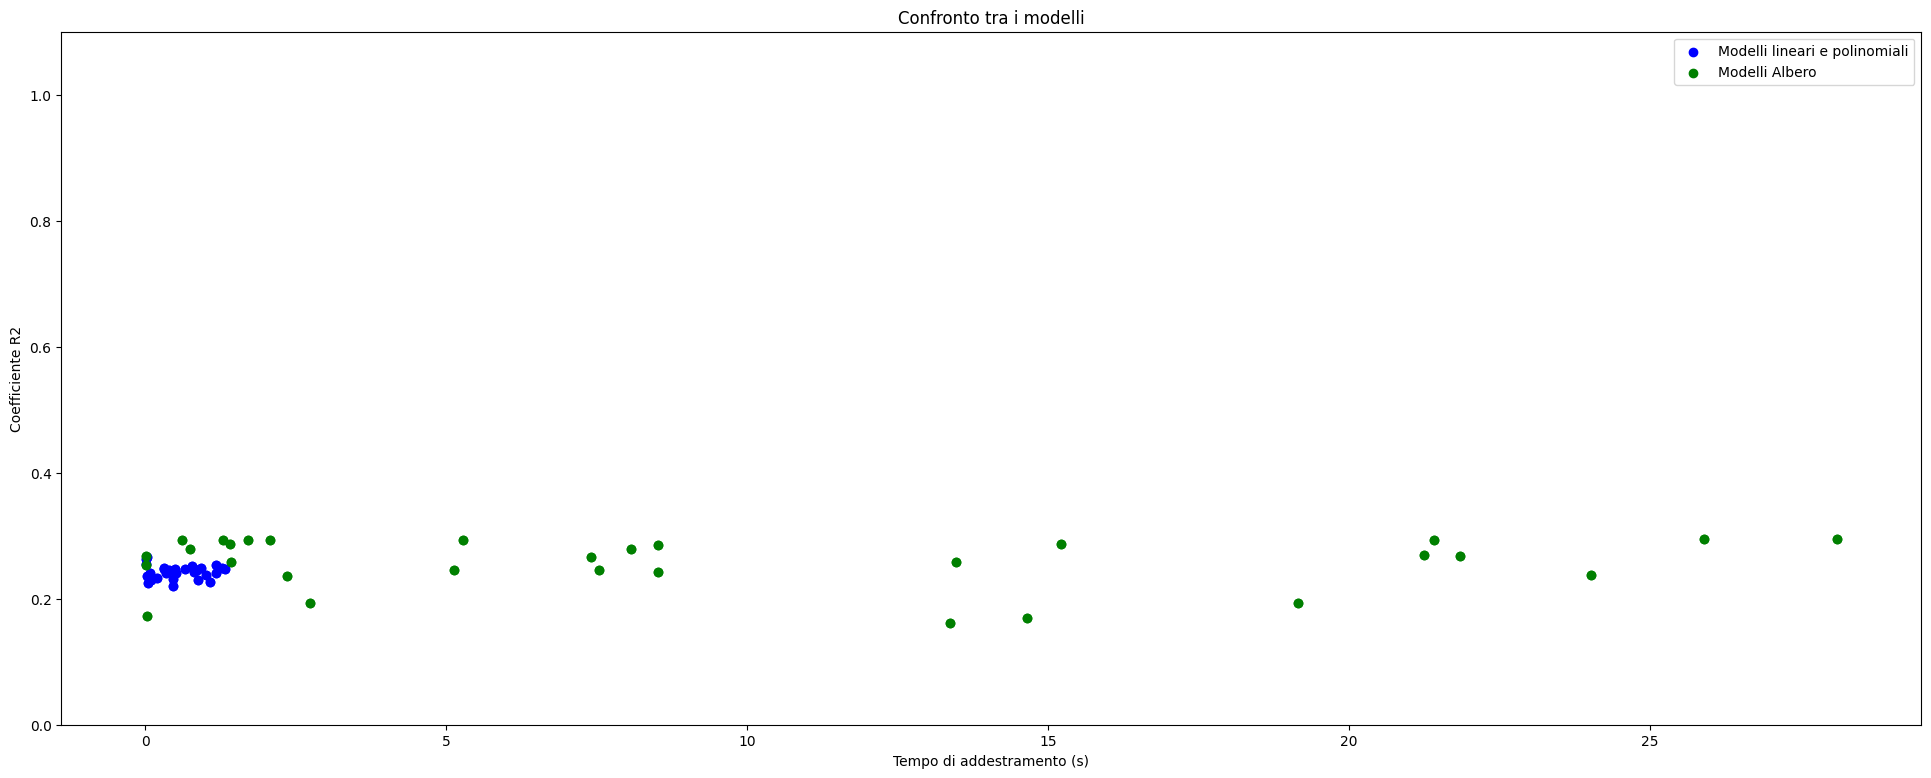

In [44]:
fig, ax = plt.subplots(figsize=(24, 9))

linear_models = pd.concat([linear_gs_res, linear_gs_res], axis=0)
scatter_linear = ax.scatter(linear_models['mean_fit_time'], linear_models['mean_test_score'], color='blue', label='Modelli lineari e polinomiali')

#krm_models = pd.concat([kernel_gs_res, kernel_gs_res], axis=0)
#scatter_kernel = ax.scatter(krm_models['mean_fit_time'], krm_models['mean_test_score'], color='red', label='Modelli Kernel')

tree_models = pd.concat([watt_tree_gs_res, watt_tree_gs_res], axis=0)
scatter_tree = ax.scatter(tree_models['mean_fit_time'], tree_models['mean_test_score'], color='green', label='Modelli Albero')

ax.set_xlabel('Tempo di addestramento (s)')
ax.set_ylabel('Coefficiente R2')
ax.set_title('Confronto tra i modelli')
ax.legend()
plt.ylim(0, 1.1)
plt.show()


### test predizione

In [45]:
watt_tree_gs.predict(np.array([140,90]).reshape(1, -1))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([137.50661892])

### Reti neurali

In [46]:
'''
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ("std", StandardScaler()),
    ("regressor", MLPRegressor())
])

grid = {
    "regressor__hidden_layer_sizes": [(256, 256)],
    "regressor__activation": ["relu"],
    "regressor__max_iter": [2000],
    "regressor__batch_size": [128],
    "regressor__alpha": [0.01]

}

model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)
'''

'\nfrom sklearn.neural_network import MLPRegressor\n\npipe = Pipeline([\n    ("std", StandardScaler()),\n    ("regressor", MLPRegressor())\n])\n\ngrid = {\n    "regressor__hidden_layer_sizes": [(256, 256)],\n    "regressor__activation": ["relu"],\n    "regressor__max_iter": [2000],\n    "regressor__batch_size": [128],\n    "regressor__alpha": [0.01]\n\n}\n\nmodel = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)\nmodel.fit(X_train, y_train)\nprint_eval(X_val, y_val, model)\n'

In [47]:
#pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)

In [48]:
#pd.DataFrame({'Feature': X_watt.columns, 'Weight': model.best_estimator_.named_steps['regressor'].coefs_[0].mean(axis=1)})

# Classificazione

Di seguito sono riportate le operazioni fatte per la classificazione. In particolare si è deciso di utilizzare il modello *Decision Tree Classifier*. 

Nelle celle sottostanti vengono definite delle funzioni che consentono di rappresentare graficamente le varie zone di battito e potenza in funzione del tempo trascorso in allenamento.

In [49]:
import matplotlib.patches as mpatches

def plot_scatter_zones_per_training(feature, zone):
    color_map = {1: "darkblue", 2: "blue", 3: "aquamarine", 4: "green", 5: "yellow", 6: "orange", 7: "red"}
    
    grouped_df = combined_df.groupby(combined_df.index.date)
    
    legend_patches = [mpatches.Patch(color=color, label=f'Zone {zone}') for zone, color in color_map.items()]

    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)

    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].scatter(data['time_since_start(s)'], data[feature], c=data[zone].map(color_map), s=5)
        axes[i].set_title(f'Training {allenamento}')

    fig.suptitle(f'{feature} zones for each training')
    plt.xlabel('time_since_start(s)')
    plt.ylabel(feature)
    plt.legend(handles=legend_patches, title=f'{feature} zone')
    
    plt.show()


In [50]:
def plot_zones_bars_per_training(zone):
    grouped_df = combined_df.groupby(combined_df.index.date)
    fig, axes = plt.subplots(nrows=len(grouped_df), figsize=(24, 9), sharex=True)
    for i, (allenamento, data) in enumerate(grouped_df):
        axes[i].barh(data[zone].value_counts().index, data[zone].value_counts().values)
        axes[i].set_title(f'Training {allenamento}')

    plt.xlabel('time_since_start(s)')
    plt.ylabel(zone)


## Classificazione della potenza

Abbiamo deciso di classificare la potenza sulla base della potenza istananea in funzione del tempo trascorso. Ecco perché abbiamo considerato come feature solo
- `power(watts)`
- `time_since_start(s)`

In [51]:
X = combined_df[["time_since_start(s)", "power(watts)"]]
y = combined_df['pwr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Dal grafico seguente si nota che la maggior parte del tempo ci si trova nelle zone 1 e 2, con dei picchi su quelle più alte. Inoltre si nota che negli allenamenti del 16-02-2020 e del 05-07-2020 si è passato pochissimo tempo nella zona 7 poiché in essi vi era molta salita, dunque i grafici sono compatibili con quanto detto in precedenza.

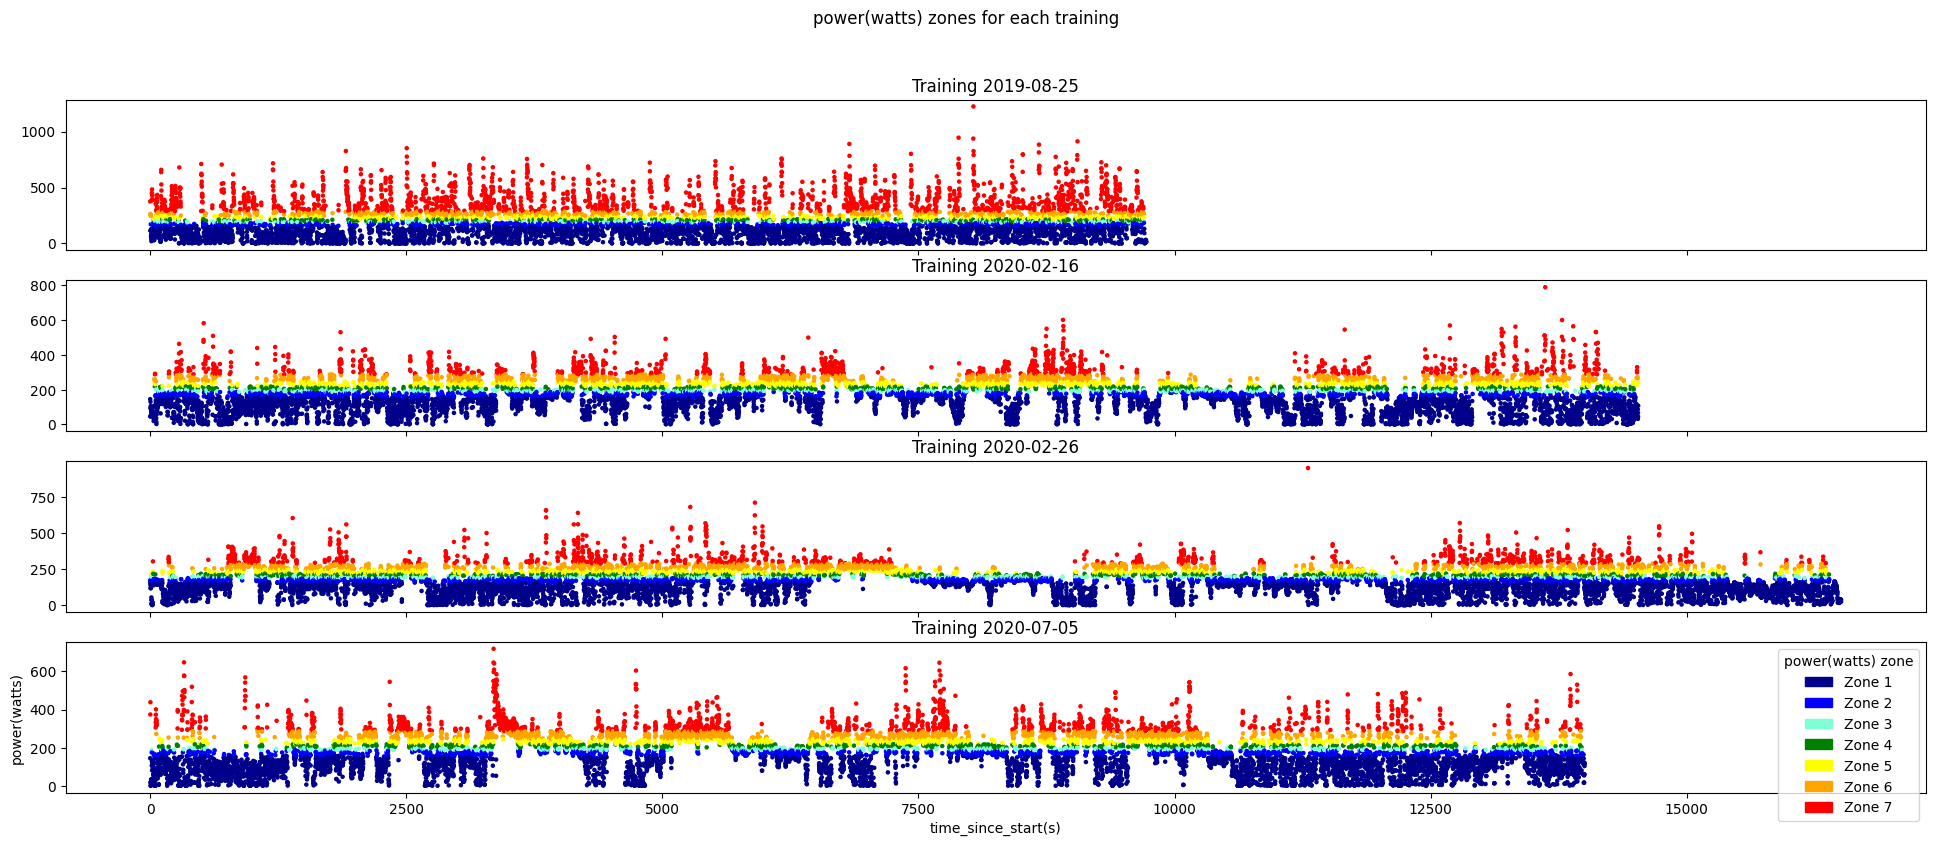

In [52]:
plot_scatter_zones_per_training('power(watts)', 'pwr_zone')

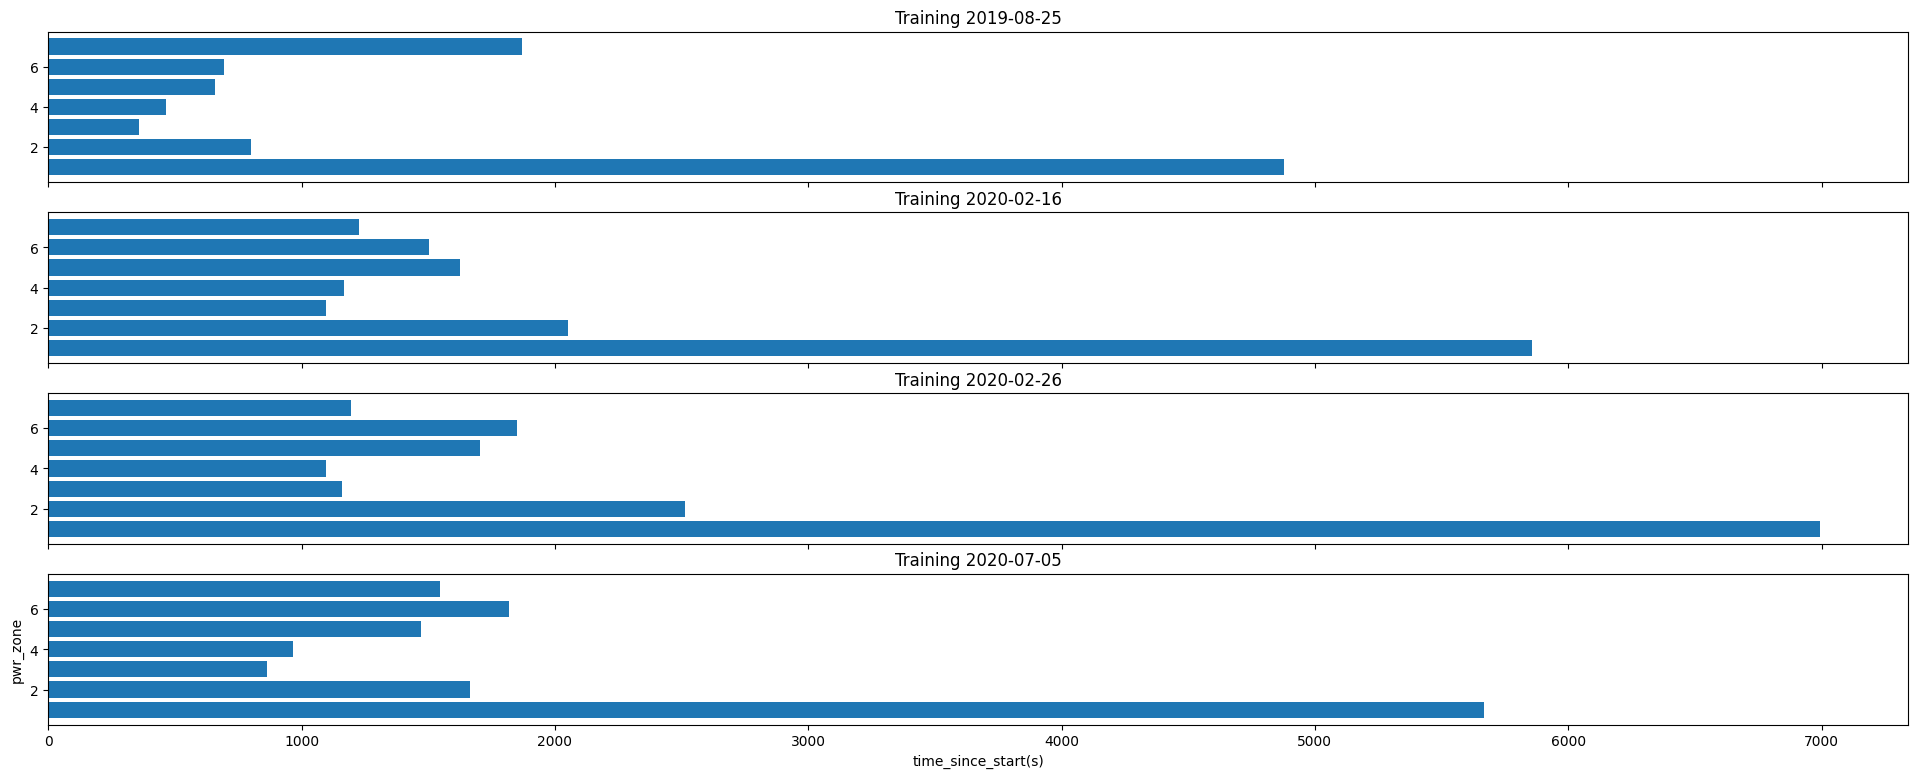

In [53]:
plot_zones_bars_per_training('pwr_zone')

Di seguito è riportata la pipeline per la classificazione della potenza. Come anticipato si è deciso di utilizzare il modello *Decision Tree Classifier*. La pipeline è composta da:
- `StandardScaler`: la grid search valuterà se è meglio standardizzare o meno i dati
- `criterion`: criterio con cui valutare la bontà di uno split
- `max_depth`: massima profondità dell'albero
- `splitter`: la strategia usata per scegliere lo split migliore su ogni nodo
- `min_samples_leaf`: numero minimo di campioni necessari per essere una foglia
- `min_samples_split`: numero minimo di campioni necessari per effettuare uno split 
- `max_features`: numero di features da considerare per la ricerca dello split migliore

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7500 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4746 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

|--- power(watts) <= 186.50
|   |--- power(watts) <= 157.50
|   |   |--- class: 1
|   |--- power(watts) >  157.50
|   |   |--- class: 2
|--- power(watts) >  186.50
|   |--- time_since_start(s) <= 9696.50
|   |   |--- power(watts) <= 247.50
|   |   |   |--- time_since_start(s) <= 7529.50
|   |   |   |   |--- power(watts) <= 218.50
|   |   |   |   |   |--- time_since_start(s) <= 7499.50
|   |   |   |   |   |   |--- power(watts) <= 200.50
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- power(watts) >  200.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- time_since_start(s) >  7499.50
|   |   |   |   |   |   |--- time_since_start(s) <= 7523.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- time_since_start(s) >  7523.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- power(watts) >  218.50
|   |   |   |   |   |--- class: 5
|   |   |   |--- time_since_start(s) >  7529.50
|   |   |   |   |--- power(watts) <= 2

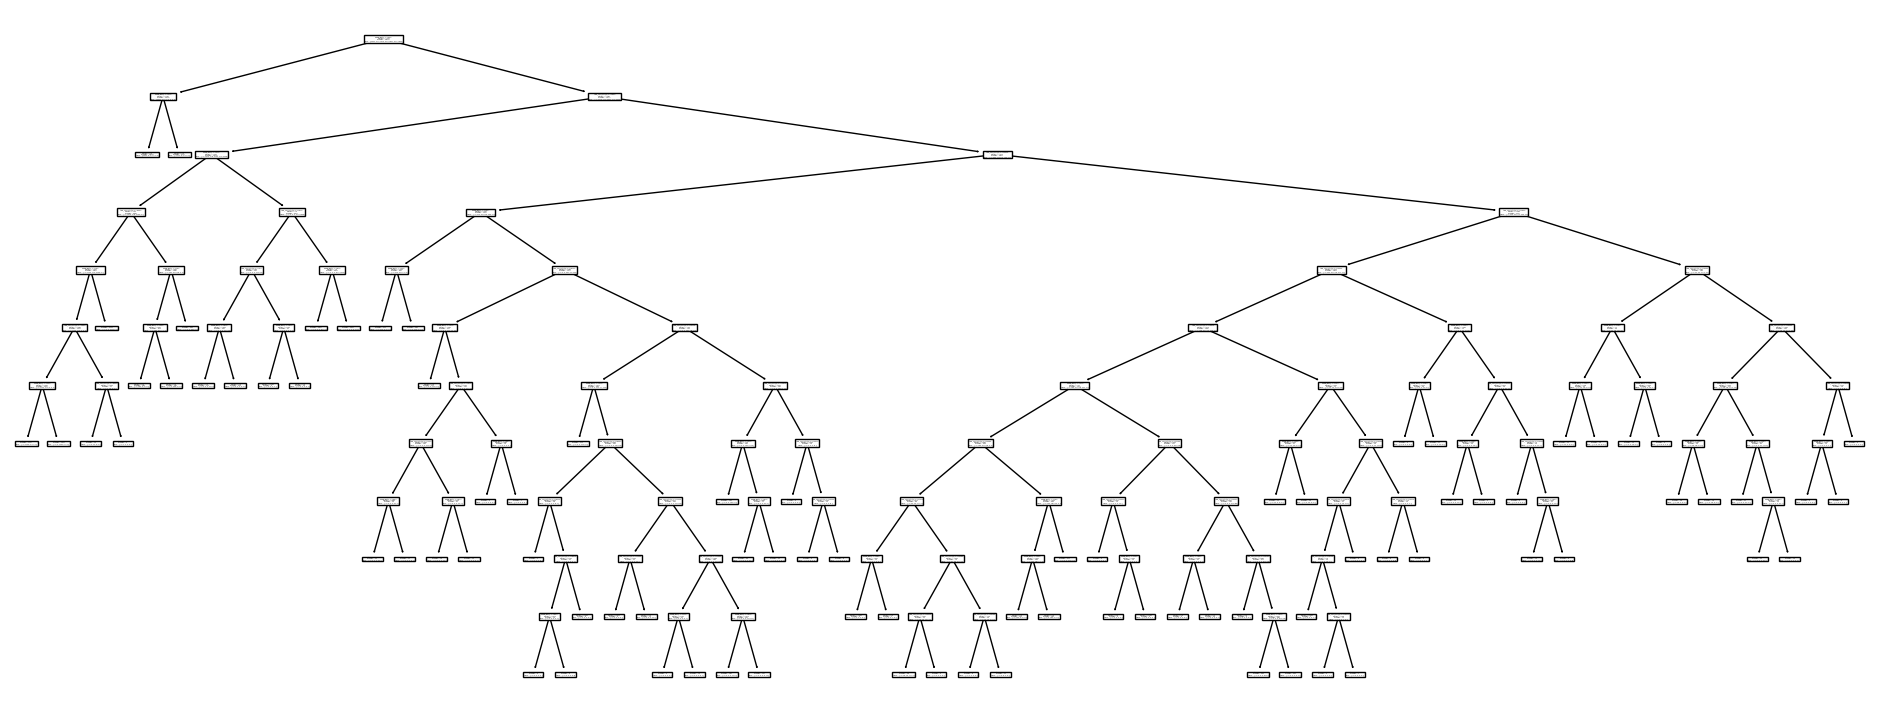

In [54]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

## Classificazione dei battiti

La classificazione dei battiti è del tutto equivalente a quella della potenza.

In [55]:
X = combined_df[["time_since_start(s)", "heart_rate(bpm)"]]
y = combined_df['hr_zone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

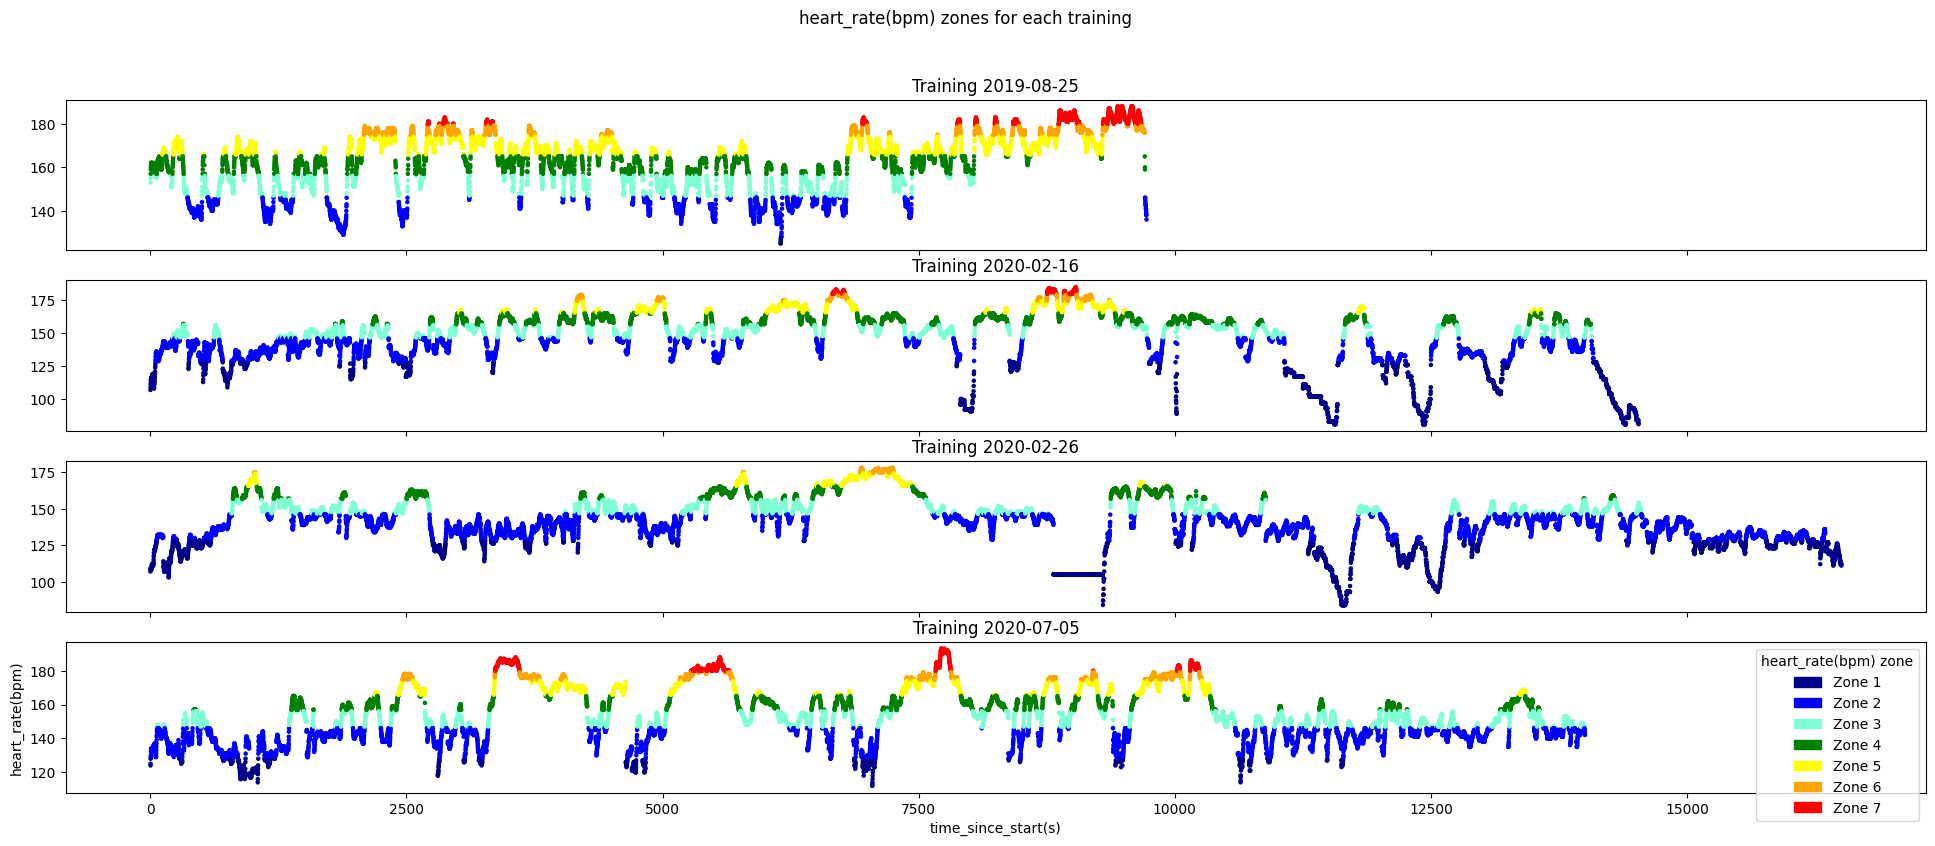

In [56]:
plot_scatter_zones_per_training('heart_rate(bpm)', 'hr_zone')

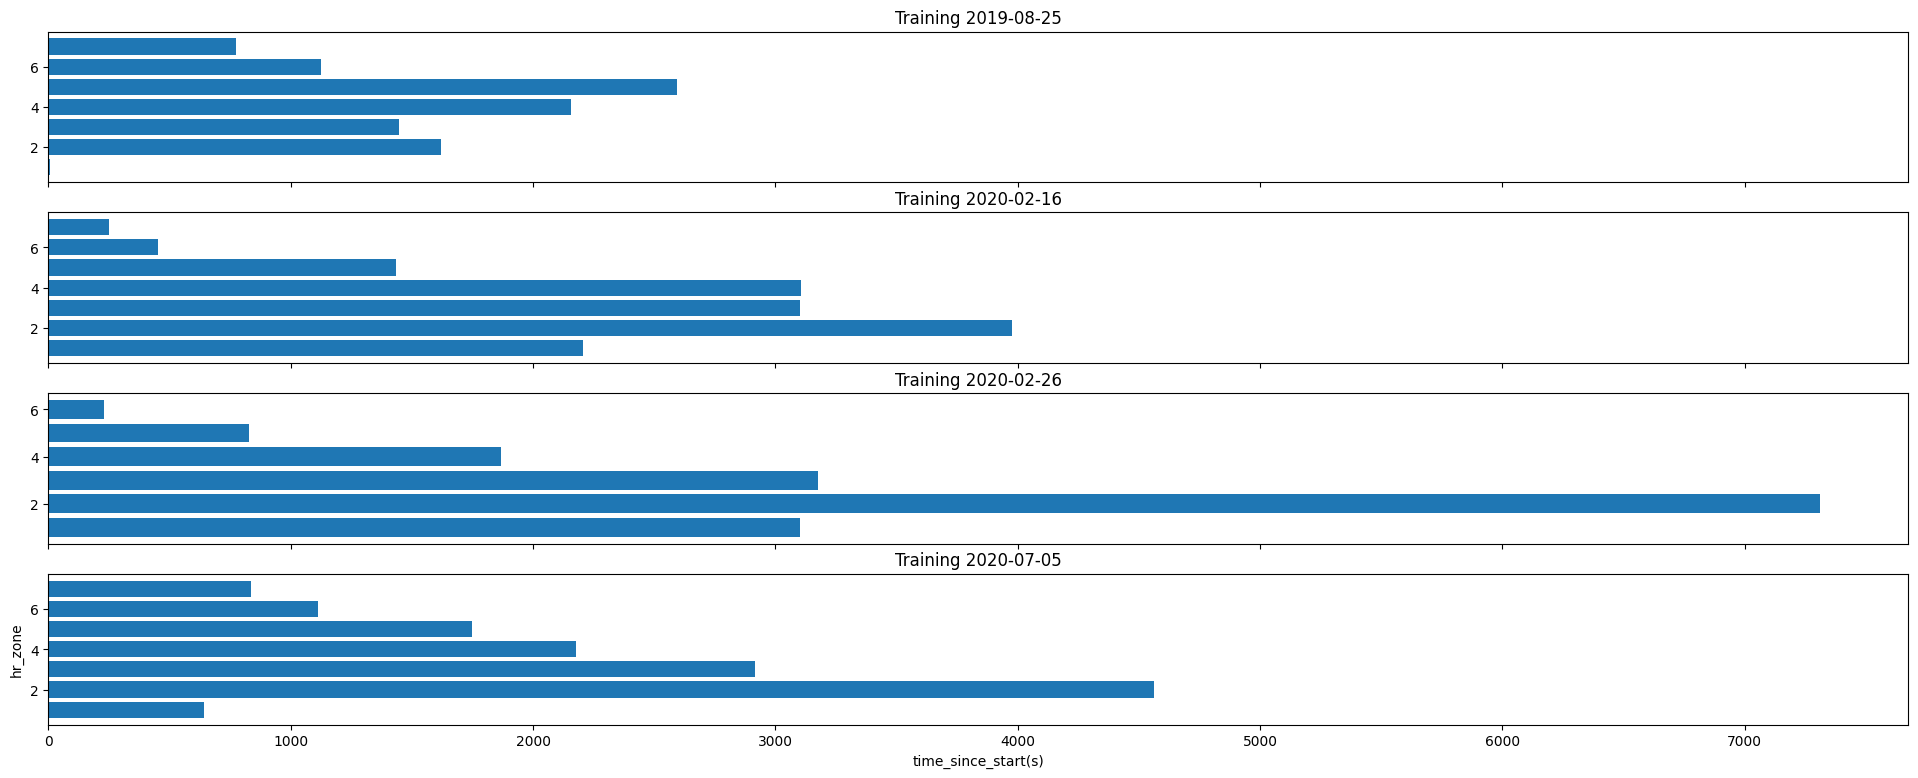

In [57]:
plot_zones_bars_per_training('hr_zone')

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
7500 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4758 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loc

|--- heart_rate(bpm) <= 146.50
|   |--- time_since_start(s) <= 8815.50
|   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |--- class: 1
|   |   |--- heart_rate(bpm) >  128.50
|   |   |   |--- class: 2
|   |--- time_since_start(s) >  8815.50
|   |   |--- time_since_start(s) <= 9343.50
|   |   |   |--- heart_rate(bpm) <= 133.00
|   |   |   |   |--- class: 1
|   |   |   |--- heart_rate(bpm) >  133.00
|   |   |   |   |--- class: 2
|   |   |--- time_since_start(s) >  9343.50
|   |   |   |--- heart_rate(bpm) <= 128.50
|   |   |   |   |--- class: 1
|   |   |   |--- heart_rate(bpm) >  128.50
|   |   |   |   |--- class: 2
|--- heart_rate(bpm) >  146.50
|   |--- time_since_start(s) <= 10369.50
|   |   |--- time_since_start(s) <= 2082.50
|   |   |   |--- heart_rate(bpm) <= 156.50
|   |   |   |   |--- class: 3
|   |   |   |--- heart_rate(bpm) >  156.50
|   |   |   |   |--- heart_rate(bpm) <= 165.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- heart_rate(bpm) >  165.50
|   |   |   |   |  

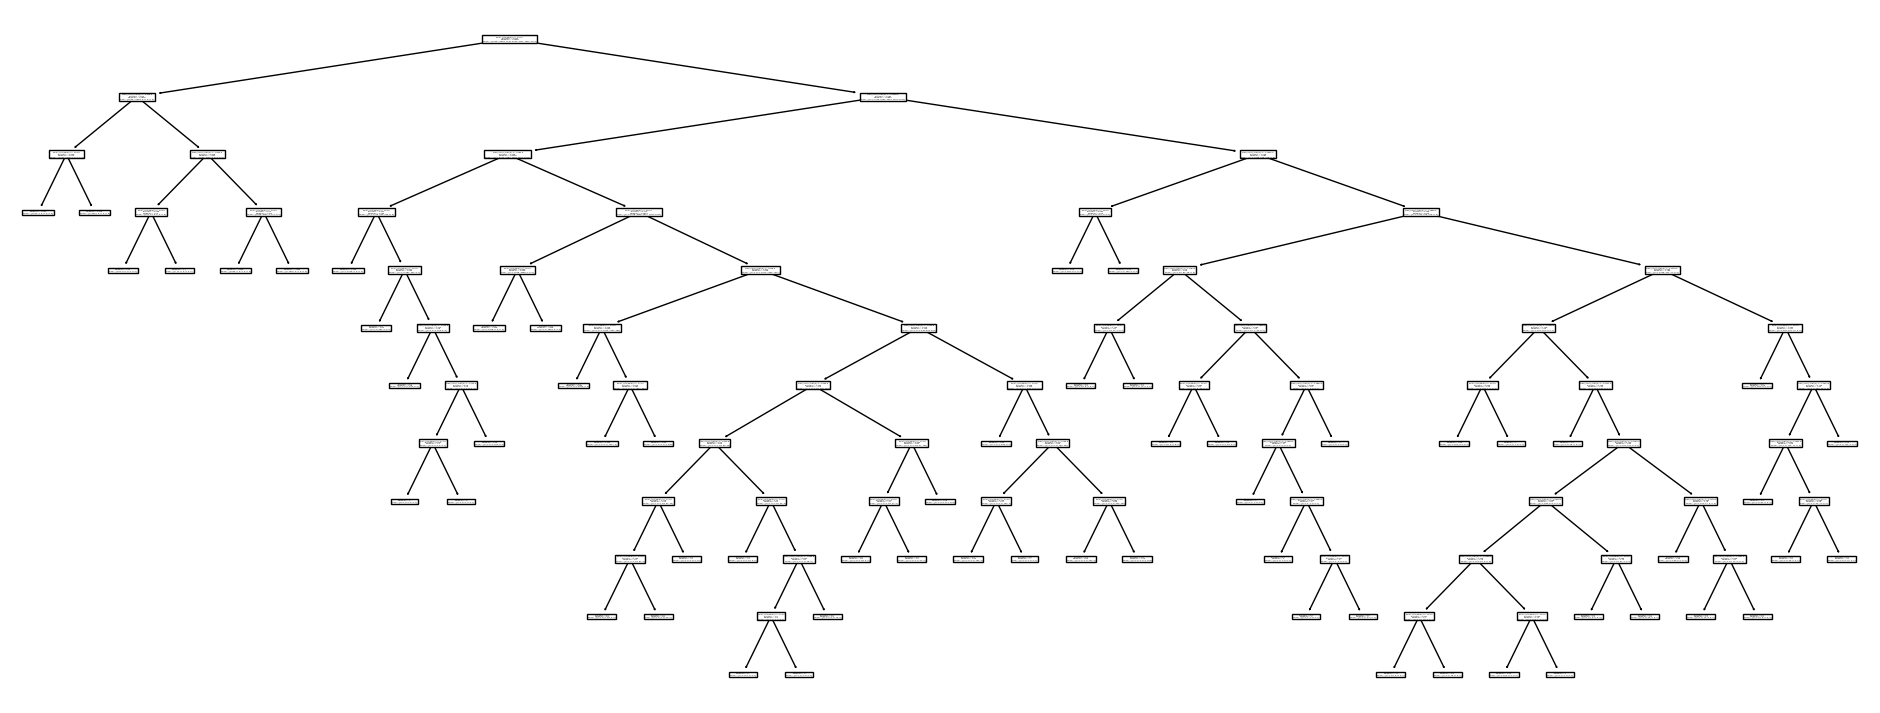

In [58]:
pipe = Pipeline([
    ("std", None),
    ("regressor", DecisionTreeClassifier())
])

grid = {
    "std": [StandardScaler(), None],
    "regressor__criterion": ["gini", "entropy", "log_loss"],
    "regressor__max_depth": [3, 5, 7, 9, 11],
    "regressor__splitter": ["best", "random"],
    "regressor__min_samples_leaf": [1, 2, 3, 4, 5],
    "regressor__min_samples_split": [2, 4, 6, 8, 10],
    "regressor__max_features": ["auto", "sqrt", "log2"]
}


model = GridSearchCV(pipe, grid, cv=kf, scoring="r2", n_jobs=-1)
model.fit(X_train, y_train)

plt.figure(figsize=(24, 9))
plot_tree(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list())
print(export_text(model.best_estimator_["regressor"], feature_names=X_train.columns.to_list()))

# Flask

Di seguito è riportato il codice di generazione di uno script python (*garmin_flask.py*) generante un file html che consente di immettere i dati di un allenamento e di ottenere la previsione del battito e della potenza a partire dai modelli migliori.

In [59]:
import os
import pickle
import flask

Il primo passo è generare dei folder su cui salvare i file necessari per la generazione del file html. In particolare vengono generati i seguenti folder:
- `templates`: contiene il file html generato
- `models`: contiene i modelli utilizzati per la previsione
- `datasets`: contiene i dataset utilizzati per la previsione

In [60]:
if not os.path.isdir("templates"):
  os.mkdir("templates")

if not os.path.isdir("models"):
  os.mkdir("models")

if not os.path.isdir("datasets"):
  os.mkdir("datasets")

Tramite `pickle` vengono salvati i modelli migliori per la previsione del battito e della potenza. Come visto sopra, i modelli migliori in entrambi i casi sono gli alberi di regressione.
In particolare
- per la previsione del battito (indica i parametri)
- per la previsione della potenza (indica i parametri)

In [61]:
with open("models/hr_model.bin", "wb") as f:
    pickle.dump(tree_gs.best_estimator_, f)

with open("models/watt_model.bin", "wb") as f:
    pickle.dump(watt_tree_gs.best_estimator_, f)

with open("datasets/hr_dataset.pkl", "wb") as f:
    pickle.dump(X_hr, f)

with open("datasets/watt_dataset.pkl", "wb") as f:
    pickle.dump(X_watt, f)

Da qui si comincia a scrivere sul file `garmin_flask.py`, importando le librerie necessarie al suo corretto funzionamento.

In [62]:
%%writefile garmin_flask.py
import os.path
import pickle
from flask import Flask, request, render_template
import numpy as np

Overwriting garmin_flask.py


Con l'attributo `-a` (append) di `%%writefile` è possibile aggiungere codice al file senza sovrascriverlo.

In [63]:
%%writefile -a garmin_flask.py

app = Flask(__name__)
app.debug = True

Appending to garmin_flask.py


In questa parte è definita la logica con cui rispondere alle richieste POST dell'utente dalla pagina HTML. In particolare, dopo aver deserializzato i dataset, se viene inviata una richiesta dalla card `hr` (corrispondente alla previsione del battito), si esegue quanto segue:
- si estraggono i dati inseriti dall'utente
  - a tal proposito occorre fare un cast a tipo int64 o float64 in base al tipo dichiarato nel dataset
- si inseriscono in una lista `inputs`
- si predice il battito corrispondente ai dati inseriti
  - occorre fare un reshape dei dati inseriti per poterli dare in pasto al modello

Completate queste operazioni si ricarica la pagina passandole il dato predetto `response`, la pagina si occuperà di inserirlo nel campo corrispondente.

In [64]:
%%writefile -a garmin_flask.py

@app.route("/", methods=["GET", "POST"])
def index():
    
    with open('datasets/hr_dataset.pkl', 'rb') as f:
        X_hr = pickle.load(f)
    with open('datasets/watt_dataset.pkl', 'rb') as f:
        X_watt = pickle.load(f)

    if request.method == "POST":
        card = request.form.get("card")

        if card == "hr":
            inputs = []
            for column_name, dtype in X_hr.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/hr_model.bin", "rb") as f:
                hr_model = pickle.load(f)
            response = hr_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", hr_pred=response, X_hr=X_hr, X_watt=X_watt)

        elif card == "watt":
            inputs = []
            for column_name, dtype in X_watt.dtypes.items():
                if dtype == "int64":
                    value = int(request.form[column_name])
                elif dtype == "float64":
                    value = float(request.form[column_name])
                inputs.append(value)
            with app.open_resource("models/watt_model.bin", "rb") as f:
                watt_model = pickle.load(f)
            response = watt_model.predict(np.array(inputs).reshape(1, -1))[0]
            return render_template("index.html", w_pred=response, X_hr=X_hr, X_watt=X_watt)

    return render_template("index.html", X_hr=X_hr, X_watt=X_watt)

Appending to garmin_flask.py


In [65]:
%%writefile -a garmin_flask.py

if __name__ == '__main__':
  app.run()

Appending to garmin_flask.py


Di seguito è riportata la pagina HTML che consente di inserire i dati e di ottenere la previsione del battito e della potenza.
Questa viene salvata all'interno di `templates/index.html`.

In [66]:
%%writefile templates/index.html

<!doctype html>
<html lang="en">

<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>Bootstrap demo</title>
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet"
    integrity="sha384-9ndCyUaIbzAi2FUVXJi0CjmCapSmO7SnpJef0486qhLnuZ2cdeRhO02iuK6FUUVM" crossorigin="anonymous">
</head>

<body class="d-flex flex-column vh-100" data-bs-theme="dark">
  <header class="d-flex justify-content-center shadow py-3">
      <h1>data intensive</h1>
  </header>
  <div class="d-flex align-items-center justify-content-center h-100">
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione battiti</h5>
        <form method="POST" action="">
          {% for column in X_hr.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="hr">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ hr_pred }}</b></p>
      </div>
    </div>
    <div class="card m-auto">
      <div class="card-body">
        <h5 class="card-title">Previsione potenza</h5>
        <form method="POST" action="">
          {% for column in X_watt.columns %}
          <div class="mb-3">
            <label for="{{ column }}" class="form-label">{{ column }}</label>
            <input name="{{ column }}" class="form-control" id="{{ column }}">
          </div>
          {% endfor %}
          <input type="hidden" name="card" value="watt">
          <button type="submit" class="btn btn-primary">Submit</button>
        </form>
      </div>
      <div class="card-footer">
        <p>Risultato: <b>{{ w_pred }}</b></p>
      </div>
    </div>
  </div>
</body>

</html>


Overwriting templates/index.html
